<a href="https://colab.research.google.com/github/ArthurMN/TEC-I/blob/main/TrabalhoFinalTECI.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

**Equipe 9**
- Yann Lucca Miranda Martins Barros - 497746
- Rafael de Araújo Frota - 554587
- Enzo Boto Vasconcelos - 510660
- Arthur Moreira do Nascimento - 474295
- Elizeu Sousa Duarte - 517113
- Francisco Caioã de Aragão Rodrigues - 499550
- Jhonanttan Willyan Souza Silveira - 511479


In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.model_selection import train_test_split, cross_val_score, GridSearchCV
from imblearn.over_sampling import SMOTE
from sklearn.preprocessing import StandardScaler, OneHotEncoder, PolynomialFeatures
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.svm import SVC, LinearSVC, SVR
from sklearn.linear_model import LinearRegression
from sklearn.metrics import (
    pairwise_distances, classification_report, confusion_matrix,
    accuracy_score, mean_absolute_error, mean_squared_error, max_error, r2_score
)
from sklearn.impute import SimpleImputer
from sklearn.neural_network import MLPRegressor

from scipy import stats
from sklearn.neighbors import KNeighborsClassifier
from sklearn.ensemble import RandomForestClassifier, RandomForestRegressor, GradientBoostingRegressor  # ou qualquer outro modelo
from sklearn.tree import DecisionTreeClassifier, plot_tree, DecisionTreeRegressor
from sklearn.model_selection import KFold, cross_val_score

# Análise do Boletim de Acidentes de Trânsito (PRF)

## 1 - Obtendo e limpando dados (PRF)


###  Carregando dataset

In [2]:
df_prf = pd.read_csv("https://drive.google.com/uc?export=download&id=1c4MpUylJSoW-WmKH4lNxY-Pm6PwrAezj", sep=';', encoding='latin1')

### Vizualização inicial

In [3]:
df_prf.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 34705 entries, 0 to 34704
Data columns (total 30 columns):
 #   Column                  Non-Null Count  Dtype  
---  ------                  --------------  -----  
 0   id                      34705 non-null  float64
 1   data_inversa            34705 non-null  object 
 2   dia_semana              34705 non-null  object 
 3   horario                 34705 non-null  object 
 4   uf                      34705 non-null  object 
 5   br                      34705 non-null  int64  
 6   km                      34705 non-null  object 
 7   municipio               34705 non-null  object 
 8   causa_acidente          34705 non-null  object 
 9   tipo_acidente           34705 non-null  object 
 10  classificacao_acidente  34704 non-null  object 
 11  fase_dia                34705 non-null  object 
 12  sentido_via             34705 non-null  object 
 13  condicao_metereologica  34705 non-null  object 
 14  tipo_pista              34705 non-null

### Tratamento de dados




#### 1. Padronização dos nomes das colunas


- Colunas convertidas para letras minúsculas.
- Espaços substituídos por underscores (`_`).
- Espaços em branco removidos das bordas dos nomes.

In [4]:
df_prf.columns = [col.strip().lower().replace(' ', '_') for col in df_prf.columns]

#### 2. Conversão de tipos de dados


- Coluna data_inversa convertida para formato datetime (datetime64[ns]).
- Coluna horario convertida para objeto de tempo (datetime.time), mantendo apenas a parte de horário.

In [5]:
df_prf['data_inversa'] = pd.to_datetime(df_prf['data_inversa'], errors='coerce')
df_prf['horario'] = df_prf['horario'].astype(str).str.strip()
df_prf['horario'] = pd.to_datetime(df_prf['horario'], format='%H:%M:%S', errors='coerce').dt.hour
df_prf.head()

,id,data_inversa,dia_semana,horario,uf,br,km,municipio,causa_acidente,tipo_acidente,...,feridos_graves,ilesos,ignorados,feridos,veiculos,latitude,longitude,regional,delegacia,uop
0,652493.0,2025-01-01,quarta-feira,6,SP,116,225,GUARULHOS,Reação tardia ou ineficiente do condutor,Tombamento,...,0,0,1,1,2,"-23,48586772","-46,54075317",SPRF-SP,DEL01-SP,UOP01-DEL01-SP
1,652519.0,2025-01-01,quarta-feira,7,CE,116,"546,2",PENAFORTE,Pista esburacada,Colisão frontal,...,0,1,4,1,6,"-7,812288","-39,08333306",SPRF-CE,DEL05-CE,UOP03-DEL05-CE
2,652522.0,2025-01-01,quarta-feira,8,PR,369,"88,2",CORNELIO PROCOPIO,Reação tardia ou ineficiente do condutor,Colisão traseira,...,0,2,0,3,2,"-23,182565","-50,637228",SPRF-PR,DEL07-PR,UOP05-DEL07-PR
3,652544.0,2025-01-01,quarta-feira,11,PR,116,74,CAMPINA GRANDE DO SUL,Reação tardia ou ineficiente do condutor,Saída de leito carroçável,...,0,4,0,1,2,"-25,36517687","-49,04223028",SPRF-PR,DEL01-PR,UOP02-DEL01-PR
4,652549.0,2025-01-01,quarta-feira,9,MG,251,471,FRANCISCO SA,Velocidade Incompatível,Colisão frontal,...,1,1,2,2,4,"-16,46801304","-43,43121303",SPRF-MG,DEL12-MG,UOP01-DEL12-MG


#### 3. Tratamento de valores nulos


- Remoção de linhas com valores nulos nas colunas críticas: classificacao_acidente, delegacia e uop.

In [6]:
df_prf = df_prf.dropna(subset=['classificacao_acidente'])
df_prf = df_prf.dropna(subset=['delegacia', 'uop'])

#### 4. Tratamento de colunas numéricas armazenadas como strings



- Substituição de vírgulas por pontos nas colunas latitude, longitude e km.
- Conversão das colunas para tipo numérico (float64), com tratamento de erros para valores inválidos.

In [7]:
df_prf['latitude'] = df_prf['latitude'].str.replace(',', '.', regex=False).astype(float)
df_prf['longitude'] = df_prf['longitude'].str.replace(',', '.', regex=False).astype(float)
df_prf['km'] = df_prf['km'].str.replace(',', '.', regex=False)
df_prf['km'] = pd.to_numeric(df_prf['km'], errors='coerce')

### Vizualização após tratamento

In [8]:
df_prf.info()
df_prf.head()

<class 'pandas.core.frame.DataFrame'>
Index: 34691 entries, 0 to 34704
Data columns (total 30 columns):
 #   Column                  Non-Null Count  Dtype         
---  ------                  --------------  -----         
 0   id                      34691 non-null  float64       
 1   data_inversa            34691 non-null  datetime64[ns]
 2   dia_semana              34691 non-null  object        
 3   horario                 34691 non-null  int32         
 4   uf                      34691 non-null  object        
 5   br                      34691 non-null  int64         
 6   km                      34691 non-null  float64       
 7   municipio               34691 non-null  object        
 8   causa_acidente          34691 non-null  object        
 9   tipo_acidente           34691 non-null  object        
 10  classificacao_acidente  34691 non-null  object        
 11  fase_dia                34691 non-null  object        
 12  sentido_via             34691 non-null  object     

,id,data_inversa,dia_semana,horario,uf,br,km,municipio,causa_acidente,tipo_acidente,...,feridos_graves,ilesos,ignorados,feridos,veiculos,latitude,longitude,regional,delegacia,uop
0,652493.0,2025-01-01,quarta-feira,6,SP,116,225.0,GUARULHOS,Reação tardia ou ineficiente do condutor,Tombamento,...,0,0,1,1,2,-23.485868,-46.540753,SPRF-SP,DEL01-SP,UOP01-DEL01-SP
1,652519.0,2025-01-01,quarta-feira,7,CE,116,546.2,PENAFORTE,Pista esburacada,Colisão frontal,...,0,1,4,1,6,-7.812288,-39.083333,SPRF-CE,DEL05-CE,UOP03-DEL05-CE
2,652522.0,2025-01-01,quarta-feira,8,PR,369,88.2,CORNELIO PROCOPIO,Reação tardia ou ineficiente do condutor,Colisão traseira,...,0,2,0,3,2,-23.182565,-50.637228,SPRF-PR,DEL07-PR,UOP05-DEL07-PR
3,652544.0,2025-01-01,quarta-feira,11,PR,116,74.0,CAMPINA GRANDE DO SUL,Reação tardia ou ineficiente do condutor,Saída de leito carroçável,...,0,4,0,1,2,-25.365177,-49.042230,SPRF-PR,DEL01-PR,UOP02-DEL01-PR
4,652549.0,2025-01-01,quarta-feira,9,MG,251,471.0,FRANCISCO SA,Velocidade Incompatível,Colisão frontal,...,1,1,2,2,4,-16.468013,-43.431213,SPRF-MG,DEL12-MG,UOP01-DEL12-MG


## 2 - Análise Exploratória (PRF)

Neste tópico buscaremos características que ajudem a prever e classificar acidentes por meio de `classificacao_acidente`.


#### 2.1 Análise da Variável-Alvo (`classificacao_acidente`)

A primeira e mais importante análise para um problema de classificação é verificar o balanceamento das classes.

Contagem de classes:
classificacao_acidente
Com Vítimas Feridas    26912
Sem Vítimas             5285
Com Vítimas Fatais      2494
Name: count, dtype: int64

Proporção de classes (%):
classificacao_acidente
Com Vítimas Feridas    77.576317
Sem Vítimas            15.234499
Com Vítimas Fatais      7.189185
Name: proportion, dtype: float64


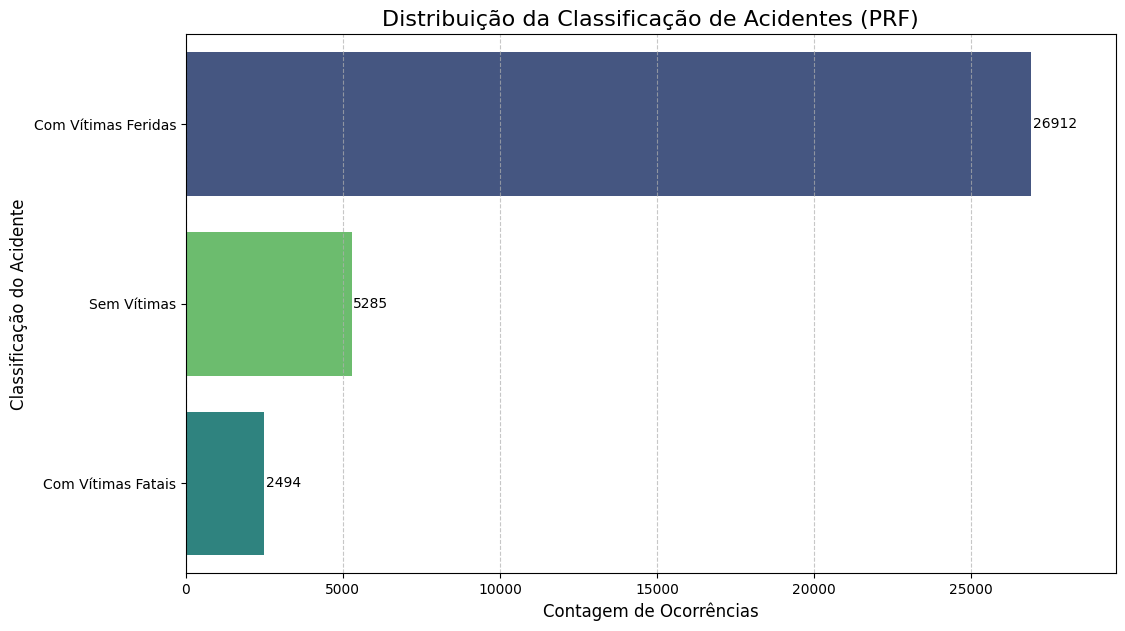

In [9]:
# Contagem e Proporção da variável-alvo
print("Contagem de classes:")
print(df_prf['classificacao_acidente'].value_counts())
print("\nProporção de classes (%):")
print(df_prf['classificacao_acidente'].value_counts(normalize=True) * 100)

# Visualização do Desbalanceamento
plt.figure(figsize=(12, 7))
ax = sns.countplot(
    y='classificacao_acidente',
    data=df_prf,
    order=df_prf['classificacao_acidente'].value_counts().index,
    palette='viridis',
    hue='classificacao_acidente',
    legend=False
)

# Adicionando rótulos de dados (a contagem) em cada barra
for p in ax.patches:
    width = p.get_width()
    plt.text(width + 50,
             p.get_y() + p.get_height() / 2,
             f'{int(width)}',
             va='center')

plt.title('Distribuição da Classificação de Acidentes (PRF)', fontsize=16)
plt.xlabel('Contagem de Ocorrências', fontsize=12)
plt.ylabel('Classificação do Acidente', fontsize=12)
plt.grid(axis='x', linestyle='--', alpha=0.7)
plt.xlim(0, df_prf['classificacao_acidente'].value_counts().max() * 1.1)
plt.show()

**Observação crítica:**
Observamos um **severo desbalanceamento de classes**. Acidentes "Com Vítimas Fatais" representam apenas cerca de **7.2%** do total. Isso é um alerta máximo para a etapa de modelagem, que deverá usar métricas apropriadas (como F1-Score ou Recall) e técnicas de reamostragem (como SMOTE) para evitar que o modelo simplesmente ignore a classe minoritária.

#### 2.2 Análise Bivariada (Relações com a gravidade do acidente)

Vamos cruzar variáveis para ver quais estão mais associadas a acidentes graves. Usaremos a tabela de contingência normalizada, que é mais informativa que a contagem bruta.

In [10]:
# Tabela de contingência normalizada para Causa do Acidente
causa_crosstab = pd.crosstab(
    index=df_prf['causa_acidente'],
    columns=df_prf['classificacao_acidente'],
    normalize='index'
)

# Selecionando as causas com maior proporção de vítimas fatais
top_causas_fatais = causa_crosstab.sort_values(by='Com Vítimas Fatais', ascending=False)

print("As 10 principais causas com maior percentual de vítimas fatais:")
display(top_causas_fatais.head(10) * 100)

As 10 principais causas com maior percentual de vítimas fatais:


classificacao_acidente,Com Vítimas Fatais,Com Vítimas Feridas,Sem Vítimas
causa_acidente,,,
Suicídio (presumido),54.838710,40.860215,4.301075
Pedestre andava na pista,43.894389,56.105611,0.000000
Entrada inopinada do pedestre,31.089744,64.743590,4.166667
Transitar na contramão,29.506803,61.649660,8.843537
Semáforo com defeito,25.000000,50.000000,25.000000
Pedestre cruzava a pista fora da faixa,24.803150,73.228346,1.968504
Transtornos Mentais (exceto suicidio),18.750000,65.625000,15.625000
Falta de acostamento,17.857143,71.428571,10.714286
Ultrapassagem Indevida,17.826618,74.358974,7.814408


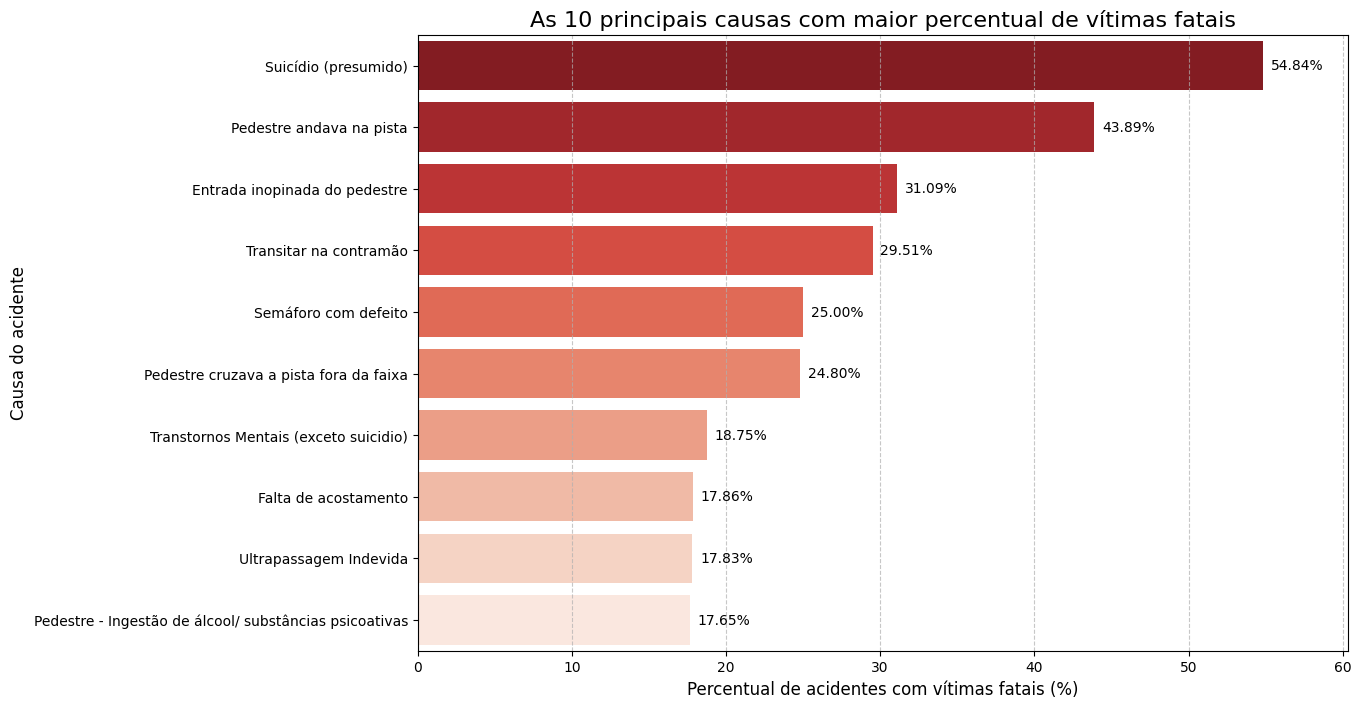

In [11]:
# Análise das 10 principais causas fatais

# Preparando os dados para o gráfico
top_10_plot = top_causas_fatais.head(10) * 100

plt.figure(figsize=(12, 8))
ax = sns.barplot(
    x=top_10_plot['Com Vítimas Fatais'],
    y=top_10_plot.index,
    palette='Reds_r',
    hue=top_10_plot.index,
    legend=False
)

# Adicionando os valores percentuais nas barras
for p in ax.patches:
    width = p.get_width()
    plt.text(width + 0.5,
             p.get_y() + p.get_height() / 2,
             f'{width:.2f}%',
             va='center')

plt.title('As 10 principais causas com maior percentual de vítimas fatais', fontsize=16)
plt.xlabel('Percentual de acidentes com vítimas fatais (%)', fontsize=12)
plt.ylabel('Causa do acidente', fontsize=12)
plt.grid(axis='x', linestyle='--', alpha=0.7)
plt.xlim(0, top_10_plot['Com Vítimas Fatais'].max() * 1.1)
plt.show()

**Observação:** A análise proporcional revela insights poderosos. Embora "Falta de Atenção à Condução" seja a causa mais frequente no geral, ela não está no topo das causas mais letais. Causas como **"Suicídio (presumido)"**, **"Pedestre andava na pista"** e **"Transitar na Contramão"** têm uma proporção muito maior de resultar em vítimas fatais, tornando-as preditores extremamente importantes.

**Análise por fase do dia**

--- Proporção de Gravidade por Fase do Dia ---


classificacao_acidente,Com Vítimas Fatais,Com Vítimas Feridas,Sem Vítimas
fase_dia,,,
Amanhecer,10.68%,69.04%,20.28%
Plena Noite,10.10%,71.29%,18.61%
Anoitecer,6.86%,79.37%,13.77%
Pleno dia,5.13%,82.00%,12.87%


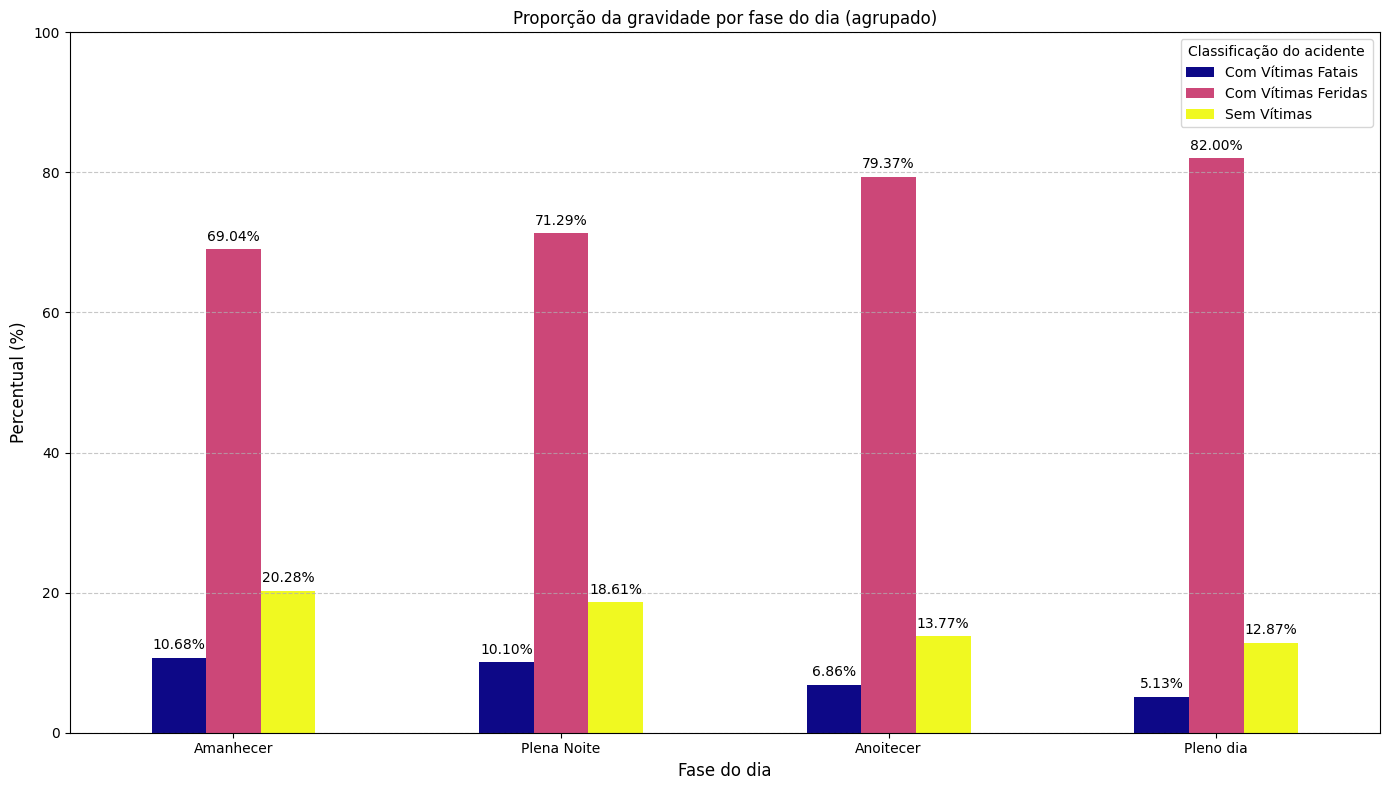

In [12]:
# Agrupando e normalizando os dados
fase_dia_crosstab = pd.crosstab(df_prf['fase_dia'], df_prf['classificacao_acidente'], normalize='index') * 100
fase_dia_crosstab = fase_dia_crosstab.sort_values(by='Com Vítimas Fatais', ascending=False)

print("--- Proporção de Gravidade por Fase do Dia ---")
display(fase_dia_crosstab.style.background_gradient(cmap='Reds', subset=['Com Vítimas Fatais']).format("{:.2f}%"))

# Criando o gráfico de barras agrupadas
ax = fase_dia_crosstab.plot(kind='bar', figsize=(14, 8), colormap='plasma',
                            title='Proporção da gravidade por fase do dia (agrupado)')

# Adicionando os rótulos de porcentagem em cada barra
for p in ax.patches:
    ax.annotate(f'{p.get_height():.2f}%',
                (p.get_x() + p.get_width() / 2., p.get_height()),
                ha='center', va='center',
                xytext=(0, 9),
                textcoords='offset points')

# Melhorando a visualização
plt.xlabel('Fase do dia', fontsize=12)
plt.ylabel('Percentual (%)', fontsize=12)
plt.xticks(rotation=0)
plt.legend(title='Classificação do acidente')
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.ylim(0, 100) # Ajustando o limite do eixo y para dar espaço aos rótulos

plt.tight_layout()
plt.show()

**Análise por Tipo de Pista**


--- Proporção de Gravidade por Tipo de Pista ---


classificacao_acidente,Com Vítimas Fatais,Com Vítimas Feridas,Sem Vítimas
tipo_pista,,,
Simples,9.78%,75.27%,14.96%
Dupla,4.96%,78.94%,16.10%
Múltipla,4.11%,82.98%,12.91%


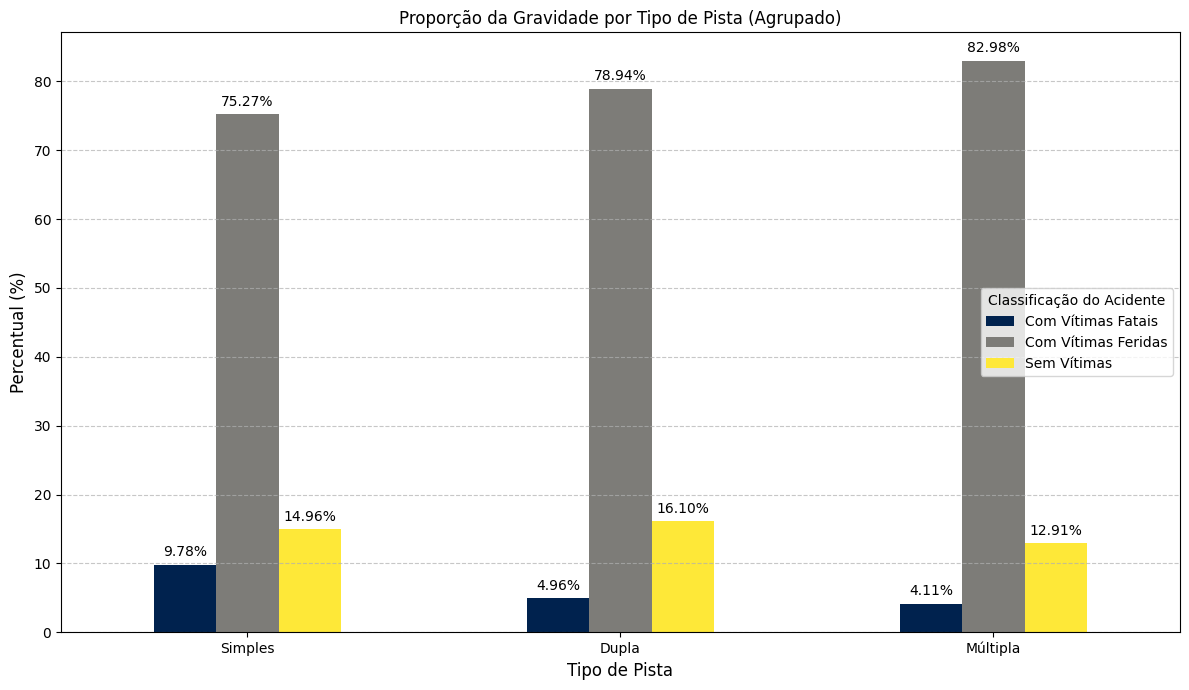

In [13]:
# Agrupando e normalizando os dados
tipo_pista_crosstab = pd.crosstab(df_prf['tipo_pista'], df_prf['classificacao_acidente'], normalize='index') * 100
tipo_pista_crosstab = tipo_pista_crosstab.sort_values(by='Com Vítimas Fatais', ascending=False)

print("\n--- Proporção de Gravidade por Tipo de Pista ---")
display(tipo_pista_crosstab.style.background_gradient(cmap='Reds', subset=['Com Vítimas Fatais']).format("{:.2f}%"))

# Criando o gráfico de barras agrupadas
ax = tipo_pista_crosstab.plot(kind='bar', figsize=(12, 7), colormap='cividis',
                              title='Proporção da Gravidade por Tipo de Pista (Agrupado)')

# Adicionando os rótulos de porcentagem em cada barra
for p in ax.patches:
    ax.annotate(f'{p.get_height():.2f}%',
                (p.get_x() + p.get_width() / 2., p.get_height()),
                ha='center', va='center',
                xytext=(0, 9),
                textcoords='offset points')

# Melhorando a visualização
plt.xlabel('Tipo de Pista', fontsize=12)
plt.ylabel('Percentual (%)', fontsize=12)
plt.xticks(rotation=0)
plt.legend(title='Classificação do Acidente')
plt.grid(axis='y', linestyle='--', alpha=0.7)

plt.tight_layout()
plt.show()

**Observações:**

*   **A Noite é Mais Perigosa:** Acidentes que ocorrem durante o "Amanhecer" e a "Plena Noite" têm uma proporção significativamente maior de vítimas fatais em comparação com acidentes durante o "Pleno dia". Isso pode ser atribuído a fatores como menor visibilidade, maior sonolência e, potencialmente, maior incidência de excesso de velocidade e embriaguez ao volante.
*   **A Infraestrutura da Pista é Crucial:** Pistas do tipo "Simples" têm quase o dobro da proporção de acidentes fatais em comparação com pistas "Duplas" ou "Múltiplas". Isso destaca a importância da infraestrutura rodoviária na prevenção de acidentes graves. Pistas duplas ou múltiplas geralmente separam os fluxos de tráfego, reduzindo drasticamente o risco de colisões frontais, que são as mais letais.

**Análise por Dia da Semana**


--- Proporção de Gravidade por Dia da Semana ---


classificacao_acidente,Com Vítimas Fatais,Com Vítimas Feridas,Sem Vítimas
dia_semana,,,
segunda-feira,6.24%,79.17%,14.58%
terça-feira,6.41%,80.09%,13.50%
quarta-feira,6.35%,80.56%,13.09%
quinta-feira,6.76%,79.69%,13.54%
sexta-feira,7.05%,78.69%,14.26%
sábado,8.32%,74.08%,17.60%
domingo,8.74%,72.25%,19.00%


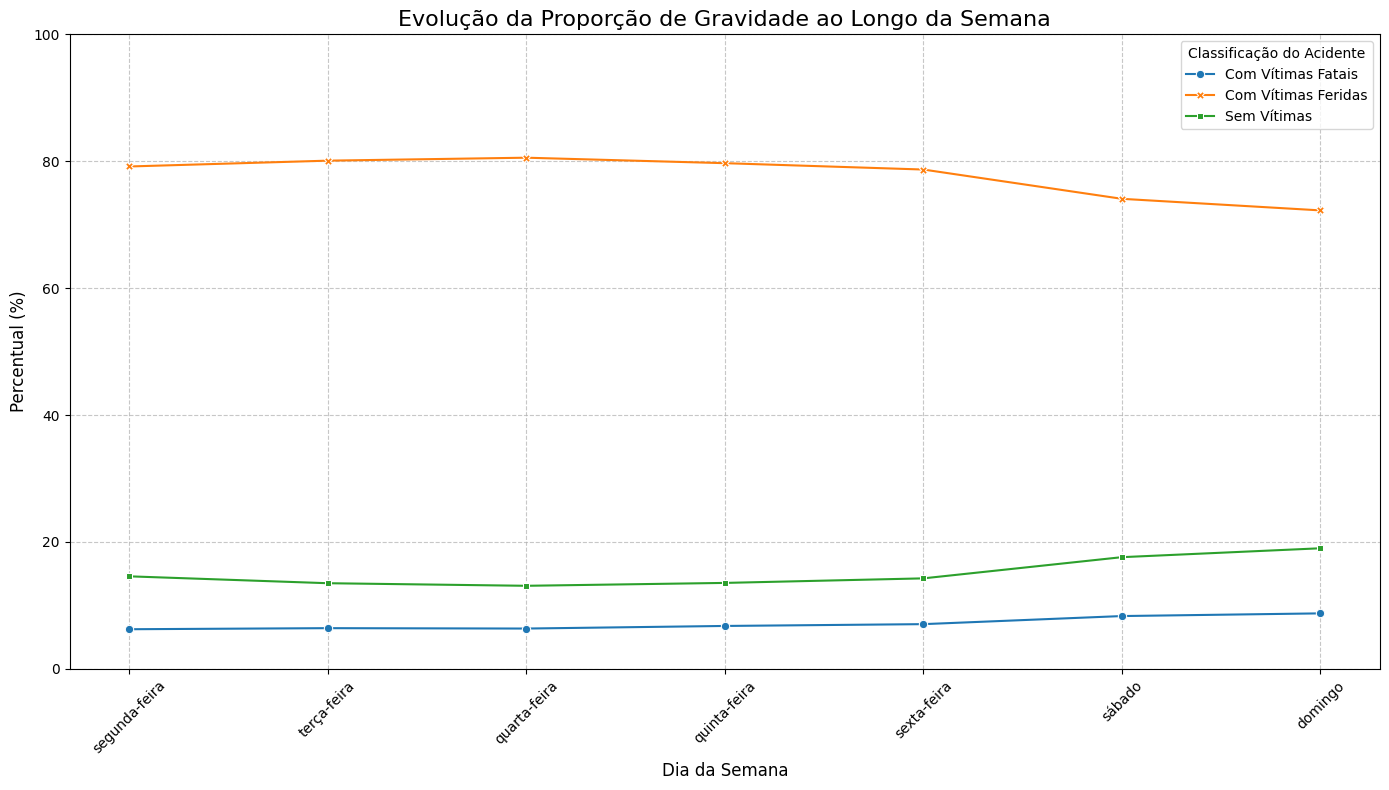

In [14]:
# Agrupando e normalizando os dados
dia_semana_crosstab = pd.crosstab(df_prf['dia_semana'], df_prf['classificacao_acidente'], normalize='index') * 100

# Ordenando os dias da semana
dias_ordenados = ['segunda-feira', 'terça-feira', 'quarta-feira', 'quinta-feira', 'sexta-feira', 'sábado', 'domingo']
dia_semana_crosstab = dia_semana_crosstab.reindex(dias_ordenados)


print("\n--- Proporção de Gravidade por Dia da Semana ---")
display(dia_semana_crosstab.style.background_gradient(cmap='Reds', subset=['Com Vítimas Fatais']).format("{:.2f}%"))

# Criando o gráfico de linhas
plt.figure(figsize=(14, 8))
ax = sns.lineplot(data=dia_semana_crosstab, markers=True, dashes=False)

# Melhorando a visualização
plt.title('Evolução da Proporção de Gravidade ao Longo da Semana', fontsize=16)
plt.xlabel('Dia da Semana', fontsize=12)
plt.ylabel('Percentual (%)', fontsize=12)
plt.xticks(rotation=45)
plt.legend(title='Classificação do Acidente')
plt.grid(True, linestyle='--', alpha=0.7)
plt.ylim(0, 100)

plt.tight_layout()
plt.show()

**Observação:**

A análise mostra uma clara tendência de aumento na letalidade dos acidentes durante o fim de semana. A proporção de acidentes com vítimas fatais é visivelmente maior no sábado e, principalmente, no domingo, em comparação com os dias úteis. Este padrão sugere que fatores comportamentais associados ao fim de semana, como viagens de lazer e possível aumento de imprudência, elevam o risco de desfechos graves.

**Análise por tipo de acidente**


--- Proporção de gravidade por tipo de acidente ---


classificacao_acidente,Com Vítimas Fatais,Com Vítimas Feridas,Sem Vítimas
tipo_acidente,,,
Colisão frontal,29.89%,64.20%,5.91%
Atropelamento de Pedestre,29.80%,68.55%,1.65%
Colisão lateral sentido oposto,9.82%,73.59%,16.59%
Eventos atípicos,9.33%,61.33%,29.33%
Colisão com objeto,6.06%,68.23%,25.70%
Saída de leito carroçável,5.87%,72.57%,21.56%
Capotamento,5.45%,80.61%,13.94%
Atropelamento de Animal,5.09%,80.91%,14.00%
Tombamento,4.38%,88.94%,6.68%


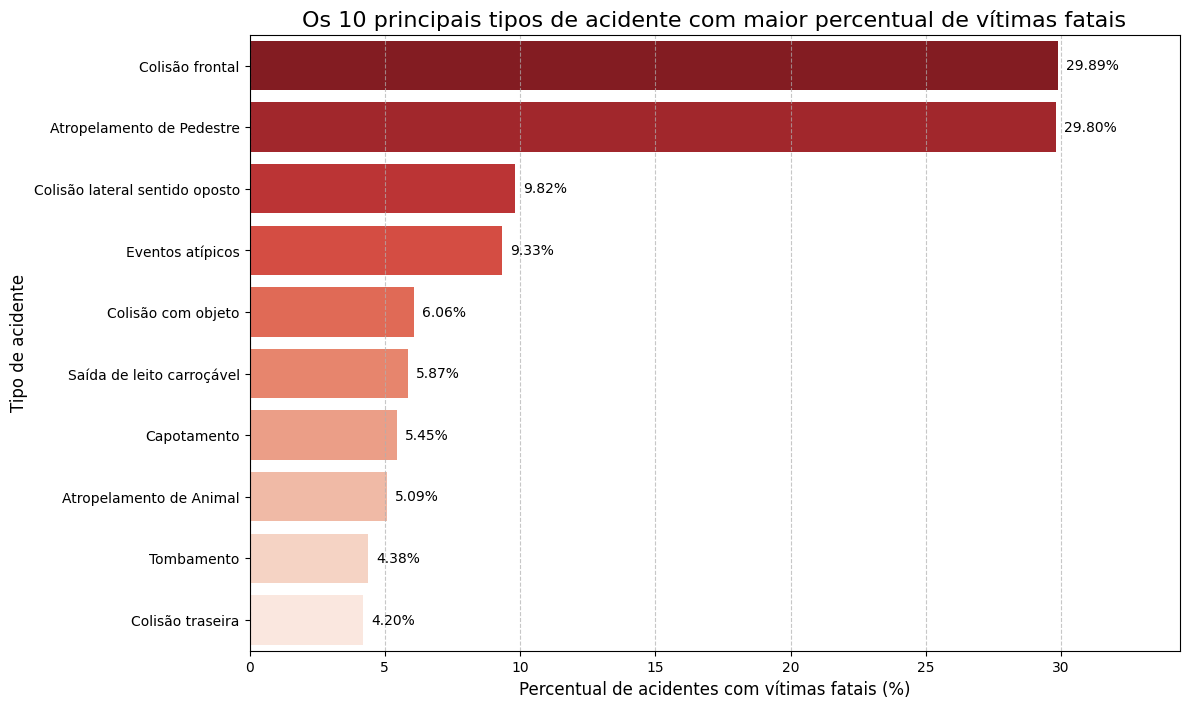

In [15]:
# Agrupando e normalizando os dados
tipo_acidente_crosstab = pd.crosstab(df_prf['tipo_acidente'], df_prf['classificacao_acidente'], normalize='index') * 100
tipo_acidente_crosstab = tipo_acidente_crosstab.sort_values(by='Com Vítimas Fatais', ascending=False)

print("\n--- Proporção de gravidade por tipo de acidente ---")
display(tipo_acidente_crosstab.head(10).style.background_gradient(cmap='Reds', subset=['Com Vítimas Fatais']).format("{:.2f}%"))

plt.figure(figsize=(12, 8))
ax = sns.barplot(
    x=tipo_acidente_crosstab.head(10)['Com Vítimas Fatais'],
    y=tipo_acidente_crosstab.head(10).index,
    palette='Reds_r',
    hue=tipo_acidente_crosstab.head(10).index,
    legend=False
)

# Adicionando os rótulos de porcentagem
for p in ax.patches:
    width = p.get_width()
    ax.text(width + 0.3, # Pequeno ajuste no posicionamento
            p.get_y() + p.get_height() / 2,
            f'{width:.2f}%',
            va='center')

plt.title('Os 10 principais tipos de acidente com maior percentual de vítimas fatais', fontsize=16)
plt.xlabel('Percentual de acidentes com vítimas fatais (%)', fontsize=12)
plt.ylabel('Tipo de acidente', fontsize=12)
plt.grid(axis='x', linestyle='--', alpha=0.7)
plt.xlim(0, tipo_acidente_crosstab.head(10)['Com Vítimas Fatais'].max() * 1.15) # Ajuste no limite para caber o texto
plt.show()

**Observações:**

A análise do tipo de acidente é um dos pilares para entendermos a gravidade das ocorrências. Os dados mostram claramente que:

*   **Colisões Frontais são as Mais Letais:** O tipo "Colisão frontal" tem a maior proporção de vítimas fatais, com quase 30%. Isso é esperado, pois a energia combinada dos veículos em direções opostas resulta em impactos de altíssima severidade.
*   **A Vulnerabilidade do Pedestre:** Logo em seguida, "Atropelamento de Pedestre" também apresenta uma taxa de fatalidade próxima de 30%. Isso expõe a extrema vulnerabilidade do pedestre em colisões com veículos, mesmo em velocidades mais baixas.
*   **Impactos Laterais e Saídas de Pista:** Acidentes como "Colisão lateral sentido oposto", "Saída de leito carroçável" e "Capotamento" também apresentam taxas de fatalidade significativas, embora menores que as colisões frontais. Isso reforça que qualquer perda de controle do veículo ou invasão da pista contrária tem um potencial de risco muito elevado.

**Análise por condição metereológica**


--- Proporção de Gravidade por Condição Metereológica ---


classificacao_acidente,Com Vítimas Fatais,Com Vítimas Feridas,Sem Vítimas
condicao_metereologica,,,
Ignorado,10.15%,70.41%,19.44%
Nevoeiro/Neblina,10.03%,72.17%,17.80%
Vento,8.89%,71.11%,20.00%
Nublado,7.40%,77.98%,14.62%
Céu Claro,7.28%,77.36%,15.36%
Chuva,6.77%,76.62%,16.61%
Garoa/Chuvisco,6.53%,75.85%,17.63%
Sol,5.52%,84.11%,10.37%


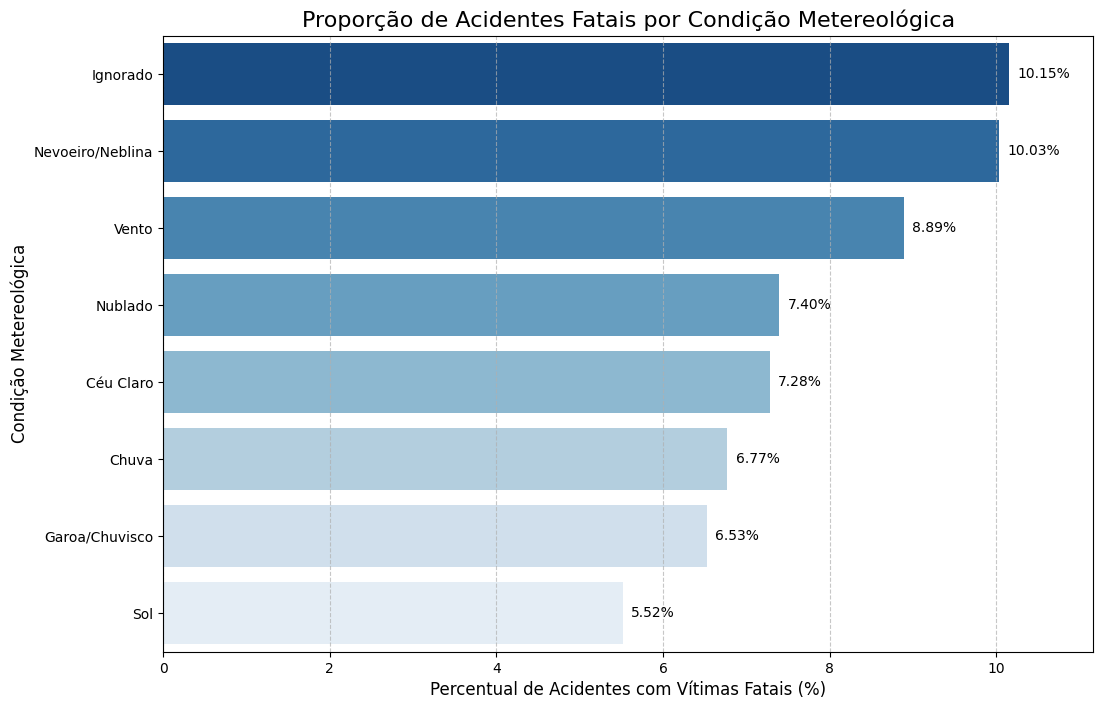

In [16]:
# Agrupando e normalizando os dados
condicao_crosstab = pd.crosstab(df_prf['condicao_metereologica'], df_prf['classificacao_acidente'], normalize='index') * 100
condicao_crosstab = condicao_crosstab.sort_values(by='Com Vítimas Fatais', ascending=False)

print("\n--- Proporção de Gravidade por Condição Metereológica ---")
display(condicao_crosstab.style.background_gradient(cmap='Reds', subset=['Com Vítimas Fatais']).format("{:.2f}%"))

plt.figure(figsize=(12, 8))
ax = sns.barplot(
    x=condicao_crosstab['Com Vítimas Fatais'],
    y=condicao_crosstab.index,
    palette='Blues_r',
    hue=condicao_crosstab.index,
    legend=False
)

# Adicionando os rótulos de porcentagem
for p in ax.patches:
    width = p.get_width()
    ax.text(width + 0.1, # Pequeno ajuste no posicionamento
            p.get_y() + p.get_height() / 2,
            f'{width:.2f}%',
            va='center')

plt.title('Proporção de Acidentes Fatais por Condição Metereológica', fontsize=16)
plt.xlabel('Percentual de Acidentes com Vítimas Fatais (%)', fontsize=12)
plt.ylabel('Condição Metereológica', fontsize=12)
plt.grid(axis='x', linestyle='--', alpha=0.7)
plt.xlim(0, condicao_crosstab['Com Vítimas Fatais'].max() * 1.1) # Ajuste no limite para caber o texto
plt.show()

**Observações:**

A análise das condições climáticas nos traz alguns insights importantes e até contraintuitivos:

*   **O "Ignorado" como Sinal de Alerta:** A categoria "Ignorado" apresenta a maior taxa de fatalidade. Conforme discutido, isso provavelmente não significa que uma condição desconhecida é perigosa, mas sim que em acidentes muito graves e caóticos, o preenchimento de campos secundários como o clima é deixado de lado, tornando "Ignorado" um indicador indireto da severidade do acidente.
*   **Condições de Baixa Visibilidade são Críticas:** "Nevoeiro/Neblina" aparece logo em seguida como a condição mais perigosa, o que é esperado, já que a redução drástica da visibilidade aumenta o risco de colisões em alta velocidade sem tempo de reação.
*   **O Paradoxo da Chuva:** Curiosamente, condições como "Chuva" e "Garoa/Chuvisco" apresentam uma proporção de acidentes fatais menor do que "Céu Claro" ou "Nublado". Uma possível explicação é que, embora a chuva possa aumentar a *frequência* de acidentes (pista escorregadia, etc.), os motoristas tendem a dirigir de forma mais cautelosa e em velocidades mais baixas, o que pode reduzir a *gravidade* dos impactos quando eles ocorrem.

#### 2.3 Conclusões e Hipóteses (PRF)

A exploração nos permite formular as seguintes hipóteses para o modelo de **Classificação**:

* **Hipótese 1: A Causa do Acidente é o Preditor Mais Forte.** Certas categorias de `causa_acidente`, especialmente as que envolvem comportamentos de alto risco ou vulnerabilidade (pedestres, contramão), serão as features com maior poder de predição para a classe "Com Vítimas Fatais".

* **Hipótese 2: O Tipo de Colisão Determina a Energia do Impacto e a Gravidade.** O `tipo_acidente` será uma variável crucial. Tipos como "Colisão frontal" e "Atropelamento de Pedestre" transferem mais energia aos envolvidos e, portanto, devem estar fortemente correlacionados com acidentes de maior gravidade.

* **Hipótese 3: Fatores Temporais, Climáticos e de Infraestrutura Modulam o Risco.** Embora talvez não sejam os preditores primários, `dia_semana` (fins de semana), `fase_dia` (noite), `condicao_metereologica` (neblina) e `tipo_pista` (pista simples) funcionarão como importantes moduladores de risco, aumentando a probabilidade de um desfecho grave quando combinados com outras causas.

### Reformulação das Hipóteses (Pós-Análise e Modelagem)

Após a análise exploratória detalhada e a observação dos resultados do modelo de classificação, podemos refinar nossas hipóteses para que reflitam com maior precisão os padrões encontrados nos dados.

---

### Dataset WHO (Expectativa de Vida)

As hipóteses originais eram boas, mas podemos torná-las mais diretas e focadas nas correlações mais fortes.

*   **Hipótese 1 (Determinantes Socioeconômicos):** A expectativa de vida é **fortemente determinada** por indicadores de desenvolvimento humano e econômico. Espera-se que `schooling` (escolaridade) e `income_composition_of_resources` (IDH) apresentem as **correlações positivas mais fortes**, sendo os principais preditores de uma vida longa. O `gdp` (PIB) atuará como um fator de suporte importante, mas secundário a esses indicadores.

*   **Hipótese 2 (Impacto de Crises de Saúde):** A longevidade de uma nação é **drasticamente reduzida** por crises de saúde pública. `adult_mortality` (mortalidade adulta) e `hiv_aids` (HIV/AIDS) serão os **principais preditores negativos**, demonstrando que a falha em controlar doenças e proteger a população adulta tem o impacto mais significativo na redução da expectativa de vida.

*   **Hipótese 3 (O Abismo do Desenvolvimento):** A classificação de um país como `status` ("Desenvolvido" vs. "Em Desenvolvimento") representa a **diferença mais fundamental e divisora**. Países desenvolvidos apresentarão, em média, uma expectativa de vida e níveis de escolaridade **significativamente superiores e com menor variabilidade**, confirmando que o status é um forte preditor categórico que encapsula um conjunto de condições favoráveis.

---

### Dataset PRF (Gravidade de Acidentes)

Aqui, podemos ir além da análise exploratória e incorporar os **pesos (coeficientes)** que o seu modelo LinearSVC já calculou. As hipóteses agora não são apenas sobre o que *achamos* que é importante, mas sobre o que o *modelo aprendeu* que é importante.

*   **Hipótese 1 (Causas de Alto Risco e Comportamento do Pedestre):** A gravidade de um acidente fatal é **primariamente ditada por causas de altíssimo risco e pela interação com pedestres**. Conforme os pesos do modelo, `causa_acidente` como "Suicídio (presumido)", "Pedestre andava na pista" e "Transitar na contramão" serão os **preditores com maior peso positivo** para a classe "Com Vítimas Fatais".

*   **Hipótese 2 (Letalidade do Tipo de Colisão):** O `tipo_acidente` é um fator determinante da gravidade, com **colisões de alta energia sendo as mais letais**. O modelo deve atribuir um **peso positivo muito significativo** a "Colisão frontal" e "Atropelamento de Pedestre", confirmando que esses eventos têm a maior probabilidade de resultar em fatalidades.

*   **Hipótese 3 (Fatores Moduladores de Risco):** Fatores de infraestrutura e ambientais atuam como **moduladores críticos do risco**. O modelo identificará `tipo_pista` ("Simples") e `fase_dia` ("Plena Noite") como fatores com **pesos positivos relevantes**, enquanto condições que levam a uma condução mais cautelosa (como `condicao_metereologica` "Chuva") podem, paradoxalmente, ter um peso menor ou até negativo na previsão de acidentes *fatais*.

## 3 - Modelagem PRF

### 3.1 - **Classificação** PRF


In [17]:
featuresPRF = [
    'dia_semana',
    'condicao_metereologica',
    'tipo_acidente',
    'causa_acidente',
    'fase_dia',
    'sentido_via',
    'tipo_pista',
    'horario',
    'ignorados',
    'veiculos'
]

xPRF = df_prf[featuresPRF]
yPRF = df_prf['classificacao_acidente'].apply(lambda x: 1 if x == "Com Vítimas Fatais" else 0)

In [18]:
stringFeatures = featuresPRF.copy()
numFeatures = ['horario', 'ignorados', 'veiculos']
stringFeatures = list(set(stringFeatures) - set(numFeatures))

preprocessor = ColumnTransformer([
    ('cat', OneHotEncoder(handle_unknown='ignore'), stringFeatures),
    ('num', StandardScaler(), numFeatures)
])

xProcess = preprocessor.fit_transform(xPRF)

sm = SMOTE(random_state=42)

xRes, yRes = sm.fit_resample(xProcess, yPRF)

xTrain, xTest, yTrain, yTest = train_test_split(xRes, yRes, test_size=0.2, random_state=42)

model = LinearSVC(class_weight='balanced')
model.fit(xTrain, yTrain)

LinearSVC(class_weight='balanced')

              precision    recall  f1-score   support

           0       0.71      0.81      0.76      6437
           1       0.78      0.67      0.72      6442

    accuracy                           0.74     12879
   macro avg       0.75      0.74      0.74     12879
weighted avg       0.75      0.74      0.74     12879



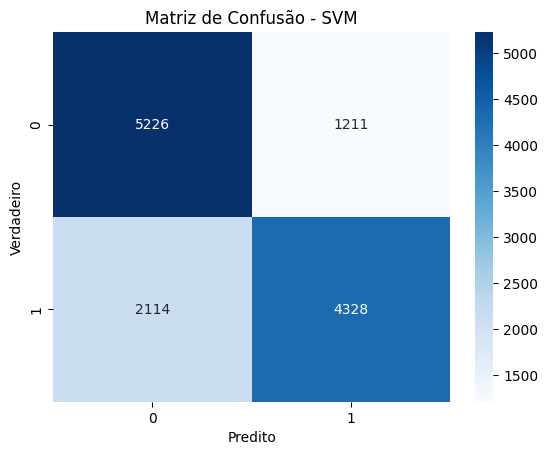

In [19]:
yPred = model.predict(xTest)

print(classification_report(yTest, yPred))
sns.heatmap(confusion_matrix(yTest, yPred), annot=True, fmt='d', cmap='Blues')
plt.xlabel("Predito")
plt.ylabel("Verdadeiro")
plt.title("Matriz de Confusão - SVM")
plt.show()

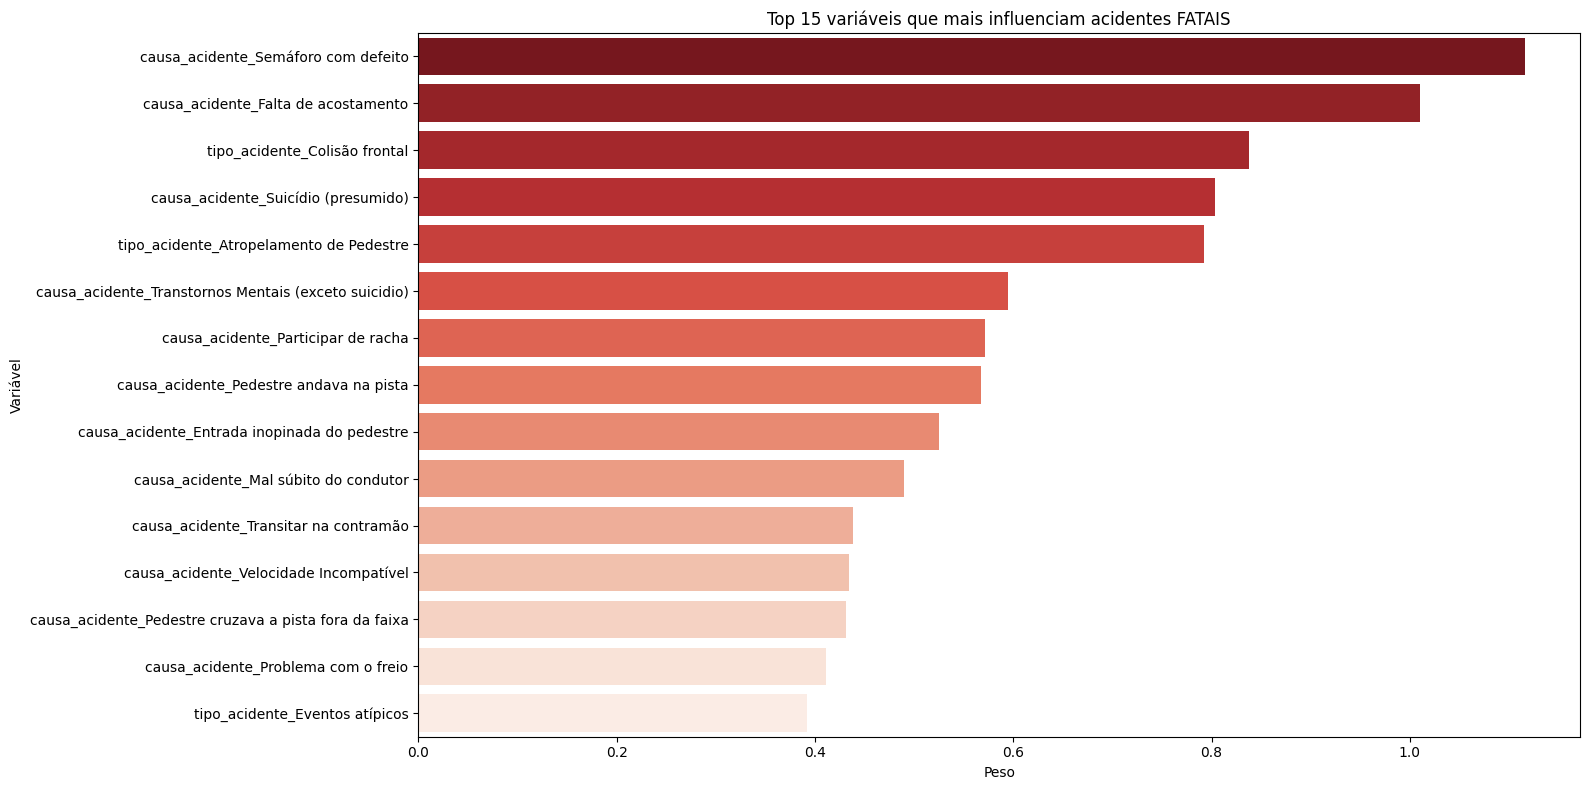

In [20]:
encodedNames = preprocessor.named_transformers_['cat'].get_feature_names_out(stringFeatures)
featureNames = np.concatenate([encodedNames, numFeatures])

coefs = model.coef_[0]
coefSeries = pd.Series(coefs, index=featureNames).sort_values(key=abs, ascending=False)

topPositivos = coefSeries.sort_values(ascending=False).head(15)
topNegativos = coefSeries.sort_values(ascending=True).head(15)

plt.figure(figsize=(16, 8))

sns.barplot(x=topPositivos.values, y=topPositivos.index, hue=topPositivos.index, legend=False, palette="Reds_r")
plt.title("Top 15 variáveis que mais influenciam acidentes FATAIS")
plt.xlabel("Peso")
plt.ylabel("Variável")

plt.tight_layout()
plt.show()

Text(0, 0.5, 'Variável')

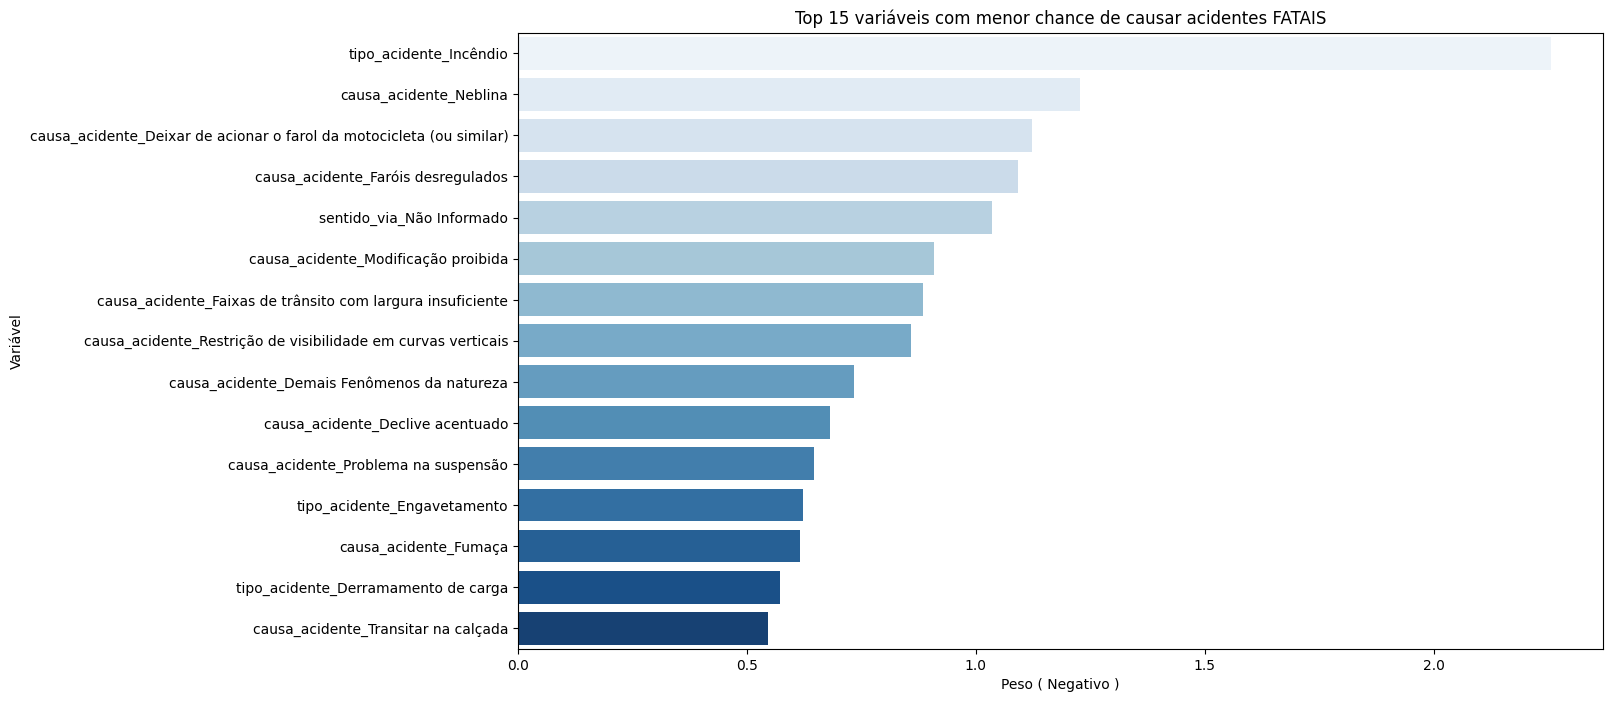

In [21]:
plt.figure(figsize=(14, 8))
sns.barplot(x=-topNegativos.values, y=topNegativos.index, hue=topNegativos.index, legend=False, palette="Blues")
plt.title("Top 15 variáveis com menor chance de causar acidentes FATAIS")
plt.xlabel("Peso ( Negativo )")
plt.ylabel("Variável")


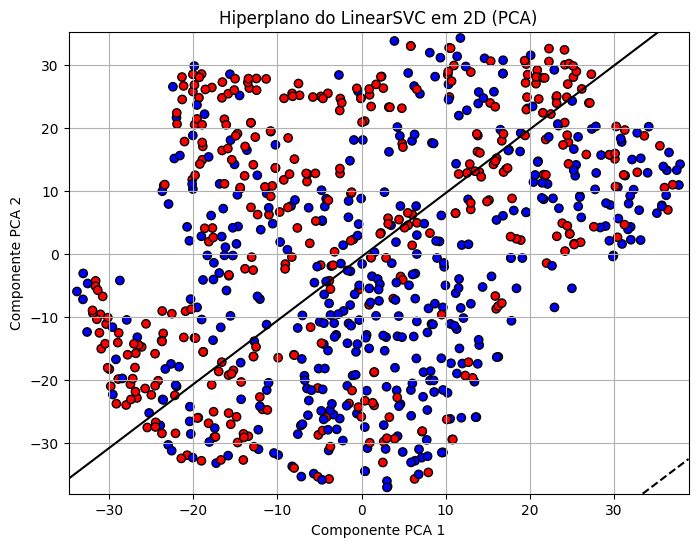

In [22]:
from sklearn.manifold import TSNE
from sklearn.utils import resample

xTrainA = xTrain.toarray() if hasattr(xTrain, 'toarray') else xTrain

xVis, yVis = resample(xTrainA, yTrain, n_samples=800, random_state=42)

tsne = TSNE(n_components=2, random_state=42)
xVis2D = tsne.fit_transform(xVis)

# Treinar modelo em 2D
model2D = LinearSVC(class_weight='balanced')
model2D.fit(xVis2D, yVis)

def plot_decision_boundary(clf, X, y):
    plt.figure(figsize=(8,6))
    colors = ['#ff9999', '#9999ff']
    cmap = plt.cm.bwr

    # Scatter
    plt.scatter(X[:, 0], X[:, 1], c=y, cmap=cmap, edgecolors='k')

    # Gerar valores para função
    x_min, x_max = X[:, 0].min() - 1, X[:, 0].max() + 1
    y_min, y_max = X[:, 1].min() - 1, X[:, 1].max() + 1
    xx, yy = np.meshgrid(np.linspace(x_min, x_max, 500),
                         np.linspace(y_min, y_max, 500))
    Z = clf.decision_function(np.c_[xx.ravel(), yy.ravel()])
    Z = Z.reshape(xx.shape)

    plt.contour(xx, yy, Z, levels=[-1, 0, 1], linestyles=['--', '-', '--'], colors='k')
    plt.title("Hiperplano do LinearSVC em 2D (PCA)")
    plt.xlabel("Componente PCA 1")
    plt.ylabel("Componente PCA 2")
    plt.grid(True)
    plt.show()

plot_decision_boundary(model2D, xVis2D, yVis)

### 3.2 - Regressão (PRF)

In [23]:
F, p = stats.f_oneway(df_prf['veiculos'], df_prf['mortos'])
print('F-statistic:', F)
print('p-value:', p)

F-statistic: 98444.89273328963
p-value: 0.0


In [24]:
X_1 = df_prf[['veiculos',]]
y_1 = df_prf['mortos']

In [25]:
print(y_1.value_counts())

mortos
0    32197
1     2223
2      200
3       46
4       12
5        9
9        2
6        1
7        1
Name: count, dtype: int64


In [26]:
X_train_1, X_test_1, y_train_1, y_test_1 = train_test_split(X_1, y_1, test_size=0.3, random_state=42)

In [27]:
model_1 = LinearRegression()

In [28]:
model_1.fit(X_train_1, y_train_1)

LinearRegression()

In [29]:
y_pred_1 = model_1.predict(X_test_1)

In [30]:
import statsmodels.api as smt

X_with_constant = smt.add_constant(X_1)  # Adicionar constante para o intercepto
model_1 = smt.OLS(y_1, X_with_constant).fit()
print(model_1.summary())

                            OLS Regression Results                            
Dep. Variable:                 mortos   R-squared:                       0.019
Model:                            OLS   Adj. R-squared:                  0.019
Method:                 Least Squares   F-statistic:                     668.4
Date:                Wed, 30 Jul 2025   Prob (F-statistic):          5.52e-146
Time:                        12:40:57   Log-Likelihood:                -10811.
No. Observations:               34691   AIC:                         2.163e+04
Df Residuals:                   34689   BIC:                         2.164e+04
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const         -0.0012      0.004     -0.324      0.7

In [31]:
mse = mean_squared_error(y_test_1, y_pred_1)
r2 = r2_score(y_test_1, y_pred_1)

print(f'Mean Squared Error: {mse}')
print(f'R² Score: {r2}')

Mean Squared Error: 0.09984714799331593
R² Score: 0.02182556617390774


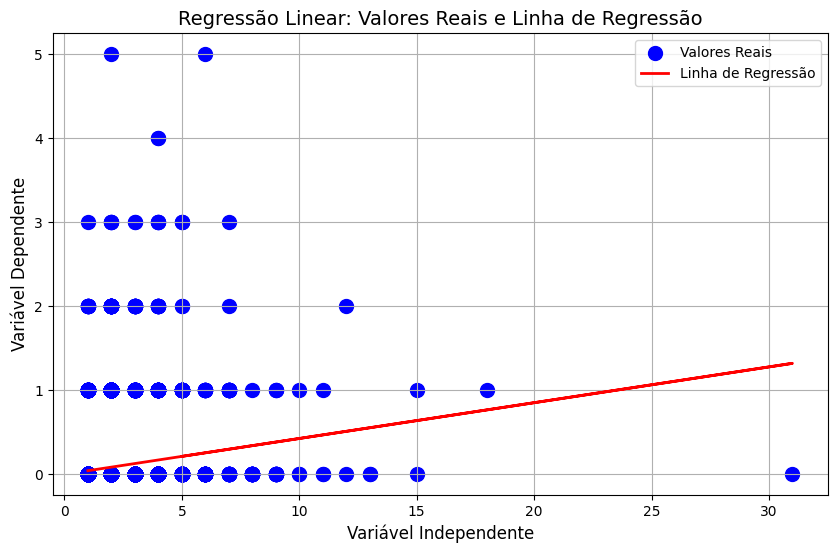

In [32]:
# Criar o gráfico
plt.figure(figsize=(10, 6))

# Gráfico de dispersão para valores reais
plt.scatter(X_test_1, y_test_1, color='blue', label='Valores Reais', s=100)

# Gráfico da linha de regressão
plt.plot(X_test_1, y_pred_1, color='red', label='Linha de Regressão', linewidth=2)

# Adicionando título e legendas
plt.title('Regressão Linear: Valores Reais e Linha de Regressão', fontsize=14)
plt.xlabel('Variável Independente', fontsize=12)
plt.ylabel('Variável Dependente', fontsize=12)
plt.legend()
plt.grid(True)

# Mostrar o gráfico
plt.show()

In [33]:
df_prf.info()

<class 'pandas.core.frame.DataFrame'>
Index: 34691 entries, 0 to 34704
Data columns (total 30 columns):
 #   Column                  Non-Null Count  Dtype         
---  ------                  --------------  -----         
 0   id                      34691 non-null  float64       
 1   data_inversa            34691 non-null  datetime64[ns]
 2   dia_semana              34691 non-null  object        
 3   horario                 34691 non-null  int32         
 4   uf                      34691 non-null  object        
 5   br                      34691 non-null  int64         
 6   km                      34691 non-null  float64       
 7   municipio               34691 non-null  object        
 8   causa_acidente          34691 non-null  object        
 9   tipo_acidente           34691 non-null  object        
 10  classificacao_acidente  34691 non-null  object        
 11  fase_dia                34691 non-null  object        
 12  sentido_via             34691 non-null  object     

In [34]:
# Selecionar características e alvo
X_2 = df_prf[['causa_acidente', 'tipo_acidente', 'condicao_metereologica', 'veiculos', 'tracado_via', 'dia_semana', 'fase_dia', 'tipo_pista', 'sentido_via', 'uso_solo',
        'pessoas', 'latitude', 'longitude', 'br', 'km']]
y_2 = df_prf['classificacao_acidente']

In [35]:
print(y_2.value_counts())

classificacao_acidente
Com Vítimas Feridas    26912
Sem Vítimas             5285
Com Vítimas Fatais      2494
Name: count, dtype: int64


In [36]:
# Convert latitude and longitude to numeric, coercing errors
df_prf['latitude'] = df_prf['latitude'].astype(str).str.replace(',', '.').astype(float)
df_prf['longitude'] = df_prf['longitude'].astype(str).str.replace(',', '.').astype(float)

# Select features and target, excluding non-numeric columns before SMOTE
X_2 = df_prf[['causa_acidente', 'tipo_acidente', 'condicao_metereologica', 'veiculos', 'tracado_via', 'dia_semana', 'fase_dia', 'tipo_pista', 'sentido_via', 'uso_solo',
        'pessoas', 'latitude', 'longitude', 'br', 'km']]
y_2 = df_prf['classificacao_acidente']

# Find the class with only one sample
class_counts = y_2.value_counts()
single_sample_class = class_counts[class_counts == 1].index.tolist()

# Remove the row(s) with the single sample class
if single_sample_class:
    print(f"Removing row(s) with class: {single_sample_class[0]}")
    df_prf = df_prf[y_2 != single_sample_class[0]]
    X_2 = df_prf[['causa_acidente', 'tipo_acidente', 'condicao_metereologica', 'veiculos', 'tracado_via', 'dia_semana', 'fase_dia', 'tipo_pista', 'sentido_via', 'uso_solo',
        'pessoas', 'latitude', 'longitude', 'br', 'km']]
    y_2 = df_prf['classificacao_acidente']


# Select only numeric columns for SMOTE
X_numeric = X_2.select_dtypes(include=np.number)

smote = SMOTE()
X_resampled, y_resampled = smote.fit_resample(X_numeric, y_2)

In [37]:
X_2 = X_resampled
y_2 = y_resampled

In [38]:
print(y_2.value_counts())

classificacao_acidente
Com Vítimas Feridas    26912
Com Vítimas Fatais     26912
Sem Vítimas            26912
Name: count, dtype: int64


In [39]:
# Separar em conjuntos de treinamento e teste
X_train_2, X_test_2, y_train_2, y_test_2 = train_test_split(X_2, y_2, test_size=0.3, random_state=42)

#### 3.2.1 Lista de modelos a serem testados

In [40]:
models = {
    'KNeighborsClassifier': KNeighborsClassifier(n_neighbors=3),
    'RandomForestClassifier': RandomForestClassifier(),
    'DecisionTreeClassifier': DecisionTreeClassifier()
}

In [41]:
# Dicionário para armazenar os resultados
results = {}

In [42]:
# Testar cada modelo
for model_name, model in models.items():
    # Criar um pipeline com escalação e o modelo
    pipeline = Pipeline([
        ('scaler', StandardScaler()),  # Escalonamento dos dados
        ('classifier', model)
    ])

    # Treinar o modelo
    pipeline.fit(X_train_2, y_train_2)

    # Fazer previsões
    y_pred_2 = pipeline.predict(X_test_2)

    # Avaliar o modelo
    report = classification_report(y_test_2, y_pred_2, output_dict=True)
    results[model_name] = report

In [43]:
# Exibir os resultados
for model_name, report in results.items():
    print(f"Resultados para {model_name}:")
    print(f"Acurácia: {report['accuracy']:.2f}")
    print(f"Precisão: {report['weighted avg']['precision']:.2f}")
    print(f"Recall: {report['weighted avg']['recall']:.2f}")
    print(f"F1-Score: {report['weighted avg']['f1-score']:.2f}\n")

Resultados para KNeighborsClassifier:
Acurácia: 0.68
Precisão: 0.68
Recall: 0.68
F1-Score: 0.68

Resultados para RandomForestClassifier:
Acurácia: 0.76
Precisão: 0.76
Recall: 0.76
F1-Score: 0.76

Resultados para DecisionTreeClassifier:
Acurácia: 0.71
Precisão: 0.71
Recall: 0.71
F1-Score: 0.71



In [44]:
model_2 = RandomForestClassifier()

In [45]:
# Definindo o K-Fold
kf = KFold(n_splits=5, shuffle=True, random_state=42)

In [46]:
# Calculando as scores de validação cruzada
scores = cross_val_score(model_2, X_2, y_2, cv=kf, scoring='accuracy')

print(f'Scores de Validação Cruzada: {scores}')
print(f'Média da Acurácia: {scores.mean()}')

Scores de Validação Cruzada: [0.77396582 0.76490989 0.76422865 0.76887347 0.76695361]
Média da Acurácia: 0.7677862888980467


In [47]:
model_2.fit(X_train_2, y_train_2)

RandomForestClassifier()

In [48]:
y_pred_2 = model_2.predict(X_test_2)

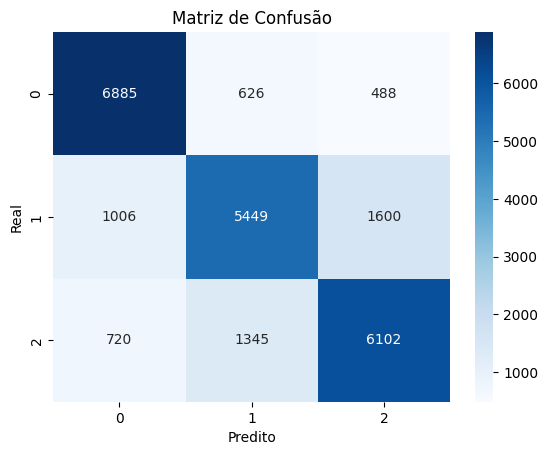

In [49]:
from sklearn.metrics import confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt

y_pred = model_2.predict(X_test_2)  # Substitua por seu conjunto de teste
cm = confusion_matrix(y_test_2, y_pred_2)
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues')
plt.xlabel('Predito')
plt.ylabel('Real')
plt.title('Matriz de Confusão')
plt.show()

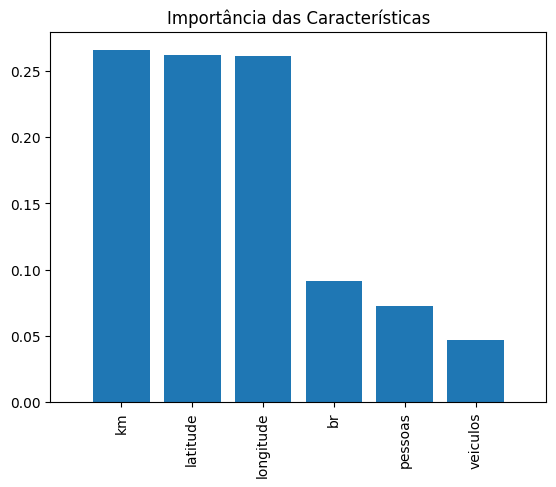

In [50]:
importances = model_2.feature_importances_
indices = np.argsort(importances)[::-1]
features = X_2.columns  # Substitua se necessário

plt.figure()
plt.title('Importância das Características')
plt.bar(range(X_2.shape[1]), importances[indices], align='center')
plt.xticks(range(X_2.shape[1]), features[indices], rotation=90)
plt.xlim([-1, X_2.shape[1]])
plt.show()

# Análise do dataset Expectativa de Vida

## 1 - Obtendo e limpando dados (WHO)

### Carregando dataset

In [51]:
df_who = pd.read_csv("https://drive.google.com/uc?export=download&id=1KsxEzGCjvNl0r4JkfcO-mkiv__trhWAW")

### Vizualização inicial

In [52]:
df_who.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2938 entries, 0 to 2937
Data columns (total 22 columns):
 #   Column                           Non-Null Count  Dtype  
---  ------                           --------------  -----  
 0   Country                          2938 non-null   object 
 1   Year                             2938 non-null   int64  
 2   Status                           2938 non-null   object 
 3   Life expectancy                  2928 non-null   float64
 4   Adult Mortality                  2928 non-null   float64
 5   infant deaths                    2938 non-null   int64  
 6   Alcohol                          2744 non-null   float64
 7   percentage expenditure           2938 non-null   float64
 8   Hepatitis B                      2385 non-null   float64
 9   Measles                          2938 non-null   int64  
 10   BMI                             2904 non-null   float64
 11  under-five deaths                2938 non-null   int64  
 12  Polio               

### Tratamento de dados

#### 1. Padronização dos nomes das colunas

- Colunas convertidas para letras minúsculas.
- Espaços substituídos por underscores (`_`).
- Espaços em branco removidos das bordas dos nomes.
- Alterações pontuais em colunas.

In [53]:
df_who.columns = [col.strip().lower().replace(' ', '_') for col in df_who.columns]
df_who.rename(columns={
    'hiv/aids': 'hiv_aids',
    'under-five_deaths': 'under_five_deaths'
}, inplace=True)

#### 2. Remoção de paises com colunas completamente nulas

In [54]:
# Transforma o DataFrame em formato long para facilitar a análise
df_null_check = df_who.set_index('country')

# Agrupa por país e verifica colunas totalmente nulas por país
paises_com_colunas_nulas = {}

for country in df_null_check.index.unique():
    df_pais = df_null_check.loc[country]
    if isinstance(df_pais, pd.Series):  # Caso só tenha uma linha do país
        df_pais = df_pais.to_frame().T
    colunas_nulas = df_pais.isna().all().loc[lambda x: x].index.tolist()
    if colunas_nulas:
        paises_com_colunas_nulas[country] = colunas_nulas

paises_a_remover = list(paises_com_colunas_nulas.keys())
df_who = df_who[~df_who['country'].isin(paises_a_remover)].reset_index(drop=True)

#### 3. Interpolação nas colunas numéricas por ano

In [55]:
# Ordena e mantém índice
df_who = df_who.sort_values(['country', 'year'])

colunas_numericas = df_who.select_dtypes(include='number').columns

# Interpolação nas colunas numéricas por grupo, mantendo índice e tamanho
df_who[colunas_numericas] = df_who.groupby('country')[colunas_numericas].transform(lambda x: x.interpolate(method='linear', limit_direction='both'))

#### 4. Preenchendo com média os valores que não foram interpolados

In [56]:
df_who[colunas_numericas] = df_who.groupby('country')[colunas_numericas].transform(lambda x: x.fillna(x.mean()))

#### 5. Preenchendo status com a moda por país.

In [57]:

df_who['status'] = df_who.groupby('country')['status'].transform(lambda x: x.fillna(x.mode().iloc[0] if not x.mode().empty else 'Developing'))

### Vizualização após tratamento

In [58]:
df_who.info()

<class 'pandas.core.frame.DataFrame'>
Index: 2128 entries, 15 to 2112
Data columns (total 22 columns):
 #   Column                           Non-Null Count  Dtype  
---  ------                           --------------  -----  
 0   country                          2128 non-null   object 
 1   year                             2128 non-null   int64  
 2   status                           2128 non-null   object 
 3   life_expectancy                  2128 non-null   float64
 4   adult_mortality                  2128 non-null   float64
 5   infant_deaths                    2128 non-null   int64  
 6   alcohol                          2128 non-null   float64
 7   percentage_expenditure           2128 non-null   float64
 8   hepatitis_b                      2128 non-null   float64
 9   measles                          2128 non-null   int64  
 10  bmi                              2128 non-null   float64
 11  under_five_deaths                2128 non-null   int64  
 12  polio                   

##2 - Análise Exploratória (WHO)

Neste tópico buscaremos entender quais fatores mais influenciam a expectativa de vida de uma nação por meio de `life_expectancy`.



In [59]:
df_who.head()

,country,year,status,life_expectancy,adult_mortality,infant_deaths,alcohol,percentage_expenditure,hepatitis_b,measles,...,polio,total_expenditure,diphtheria,hiv_aids,gdp,population,thinness__1-19_years,thinness_5-9_years,income_composition_of_resources,schooling
15,Afghanistan,2000,Developing,54.8,321.0,88,0.01,10.424960,62.0,6532,...,24.0,8.20,24.0,0.1,114.560000,293756.0,2.3,2.5,0.338,5.5
14,Afghanistan,2001,Developing,55.3,316.0,88,0.01,10.574728,63.0,8762,...,35.0,7.80,33.0,0.1,117.496980,2966463.0,2.1,2.4,0.340,5.9
13,Afghanistan,2002,Developing,56.2,3.0,88,0.01,16.887351,64.0,2486,...,36.0,7.76,36.0,0.1,187.845950,21979923.0,19.9,2.2,0.341,6.2
12,Afghanistan,2003,Developing,56.7,295.0,87,0.01,11.089053,65.0,798,...,41.0,8.82,41.0,0.1,198.728544,2364851.0,19.7,19.9,0.373,6.5
11,Afghanistan,2004,Developing,57.0,293.0,87,0.02,15.296066,67.0,466,...,5.0,8.79,5.0,0.1,219.141353,24118979.0,19.5,19.7,0.381,6.8


### 2.1. Análise Descritiva Geral

Começamos com uma visão estatística geral de todas as variáveis numéricas para entender suas escalas, tendências centrais e dispersão.

In [60]:
# Gerando o resumo estatístico para o dataset da WHO
df_who.describe()

,year,life_expectancy,adult_mortality,infant_deaths,alcohol,percentage_expenditure,hepatitis_b,measles,bmi,under_five_deaths,polio,total_expenditure,diphtheria,hiv_aids,gdp,population,thinness__1-19_years,thinness_5-9_years,income_composition_of_resources,schooling
count,2128.000000,2128.000000,2128.000000,2128.000000,2128.000000,2128.000000,2128.000000,2128.000000,2128.000000,2128.000000,2128.000000,2128.000000,2128.000000,2128.000000,2128.000000,2.128000e+03,2128.000000,2128.000000,2128.000000,2128.000000
mean,2007.500000,68.139709,174.300282,35.902726,4.348240,640.072009,74.270207,2657.467105,36.691964,49.817199,80.335996,5.899370,80.477444,2.173637,5402.417263,1.339761e+07,5.107895,5.177538,0.607481,11.691823
std,4.610856,9.610700,129.759274,136.224732,3.998403,1710.798798,28.796545,11912.236064,19.843731,185.152708,24.494233,2.305911,24.478990,5.827273,11376.222749,6.315772e+07,4.711951,4.805378,0.203404,3.203263
min,2000.000000,36.300000,1.000000,0.000000,0.010000,0.000000,2.000000,0.000000,1.400000,0.000000,3.000000,0.370000,2.000000,0.100000,1.681350,3.400000e+01,0.100000,0.100000,0.000000,0.000000
25%,2003.750000,62.000000,76.000000,1.000000,0.590000,19.883256,64.000000,0.000000,18.400000,1.000000,74.000000,4.357500,76.000000,0.100000,393.276186,1.989615e+05,1.600000,1.600000,0.476750,9.800000
50%,2007.500000,69.950000,152.000000,4.000000,3.600000,83.677991,87.000000,20.000000,38.850000,4.000000,91.000000,5.790000,91.000000,0.100000,1353.159574,1.425337e+06,3.400000,3.400000,0.649500,11.900000
75%,2011.250000,74.800000,241.250000,24.000000,7.115000,431.365149,95.000000,459.250000,55.200000,34.250000,96.000000,7.390000,96.000000,1.300000,4494.285047,7.785482e+06,7.525000,7.600000,0.747000,13.800000
max,2015.000000,89.000000,723.000000,1800.000000,17.870000,18961.348600,99.000000,212183.000000,77.600000,2500.000000,99.000000,14.390000,99.000000,50.600000,119172.741800,1.293859e+09,27.700000,28.600000,0.937000,20.700000


**Observações Iniciais:**
* **Life_expectancy:** A média de expectativa de vida é de 68.14 anos, com um desvio padrão de 9.61 anos, indicando uma variabilidade considerável entre os países.
* **GDP & Population:** Apresentam desvios padrão altíssimos em comparação com suas médias, além de uma grande diferença entre o 3º quartil (75%) e o valor máximo. Isso é um forte indício da presença de outliers (países muito ricos ou muito populosos) e de uma distribuição assimétrica.
* **Schooling:** A escolaridade varia de 0 a 20.7 anos, com uma média de 11.69 anos.


### 2.2. Análise Univariada (Distribuição das Variáveis Chave)

Vamos visualizar a distribuição da nossa variável-alvo (`life_expectancy`) e calcular suas medidas de forma (assimetria e curtose) para confirmar numericamente o que o gráfico nos mostra.

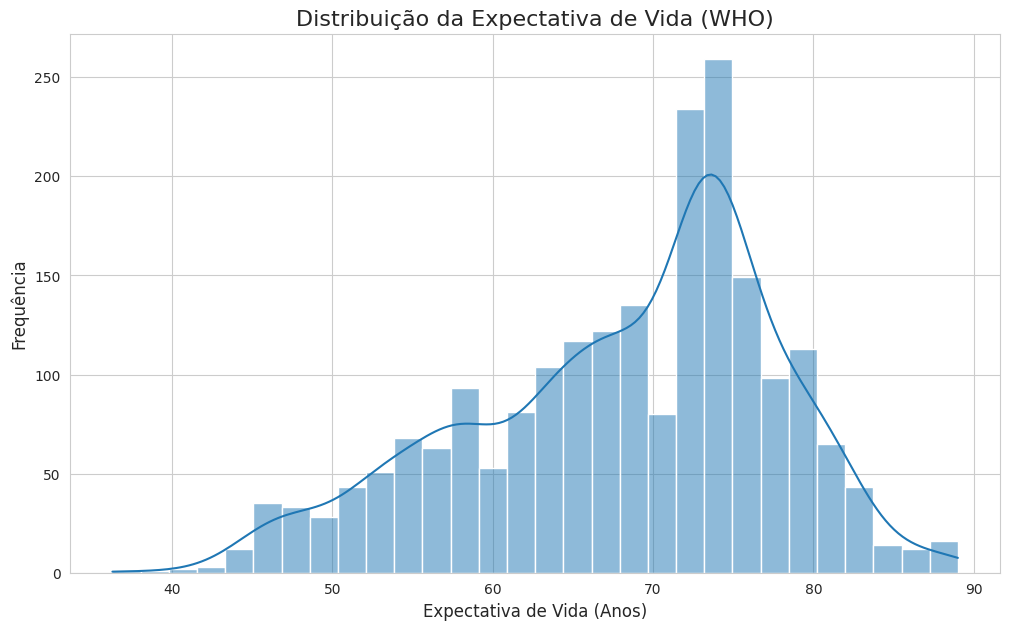

Assimetria (Skewness): -0.54
Curtose (Kurtosis): -0.33


In [61]:
# Configurando o estilo
sns.set_style('whitegrid')

# Histograma da variável-alvo
plt.figure(figsize=(12, 7))
sns.histplot(df_who['life_expectancy'], kde=True, bins=30)
plt.title('Distribuição da Expectativa de Vida (WHO)', fontsize=16)
plt.xlabel('Expectativa de Vida (Anos)', fontsize=12)
plt.ylabel('Frequência', fontsize=12)
plt.show()

# Calculando skewness e kurtosis
skewness = df_who['life_expectancy'].skew()
kurtosis = df_who['life_expectancy'].kurt()

print(f"Assimetria (Skewness): {skewness:.2f}")
print(f"Curtose (Kurtosis): {kurtosis:.2f}")

**Observações:**
* O histograma exibe uma **distribuição assimétrica à esquerda**, confirmada pelo valor de **skewness negativo (-0.54)**. Isso indica uma "cauda" de países com baixa expectativa de vida.
* O valor de **curtose próximo de zero (-0.33)** sugere que a distribuição não possui caudas pesadas, ou seja, a presença de outliers extremos na própria variável-alvo não é uma preocupação primária.

### 2.3. Análise bivariada (relações com a expectativa de vida)

Agora, o passo mais importante para a regressão: investigar como as outras variáveis se correlacionam com a `life_expectancy`.

**Mapa de calor de correlação**

Para uma visão geral e rápida, o mapa de calor é a melhor ferramenta.

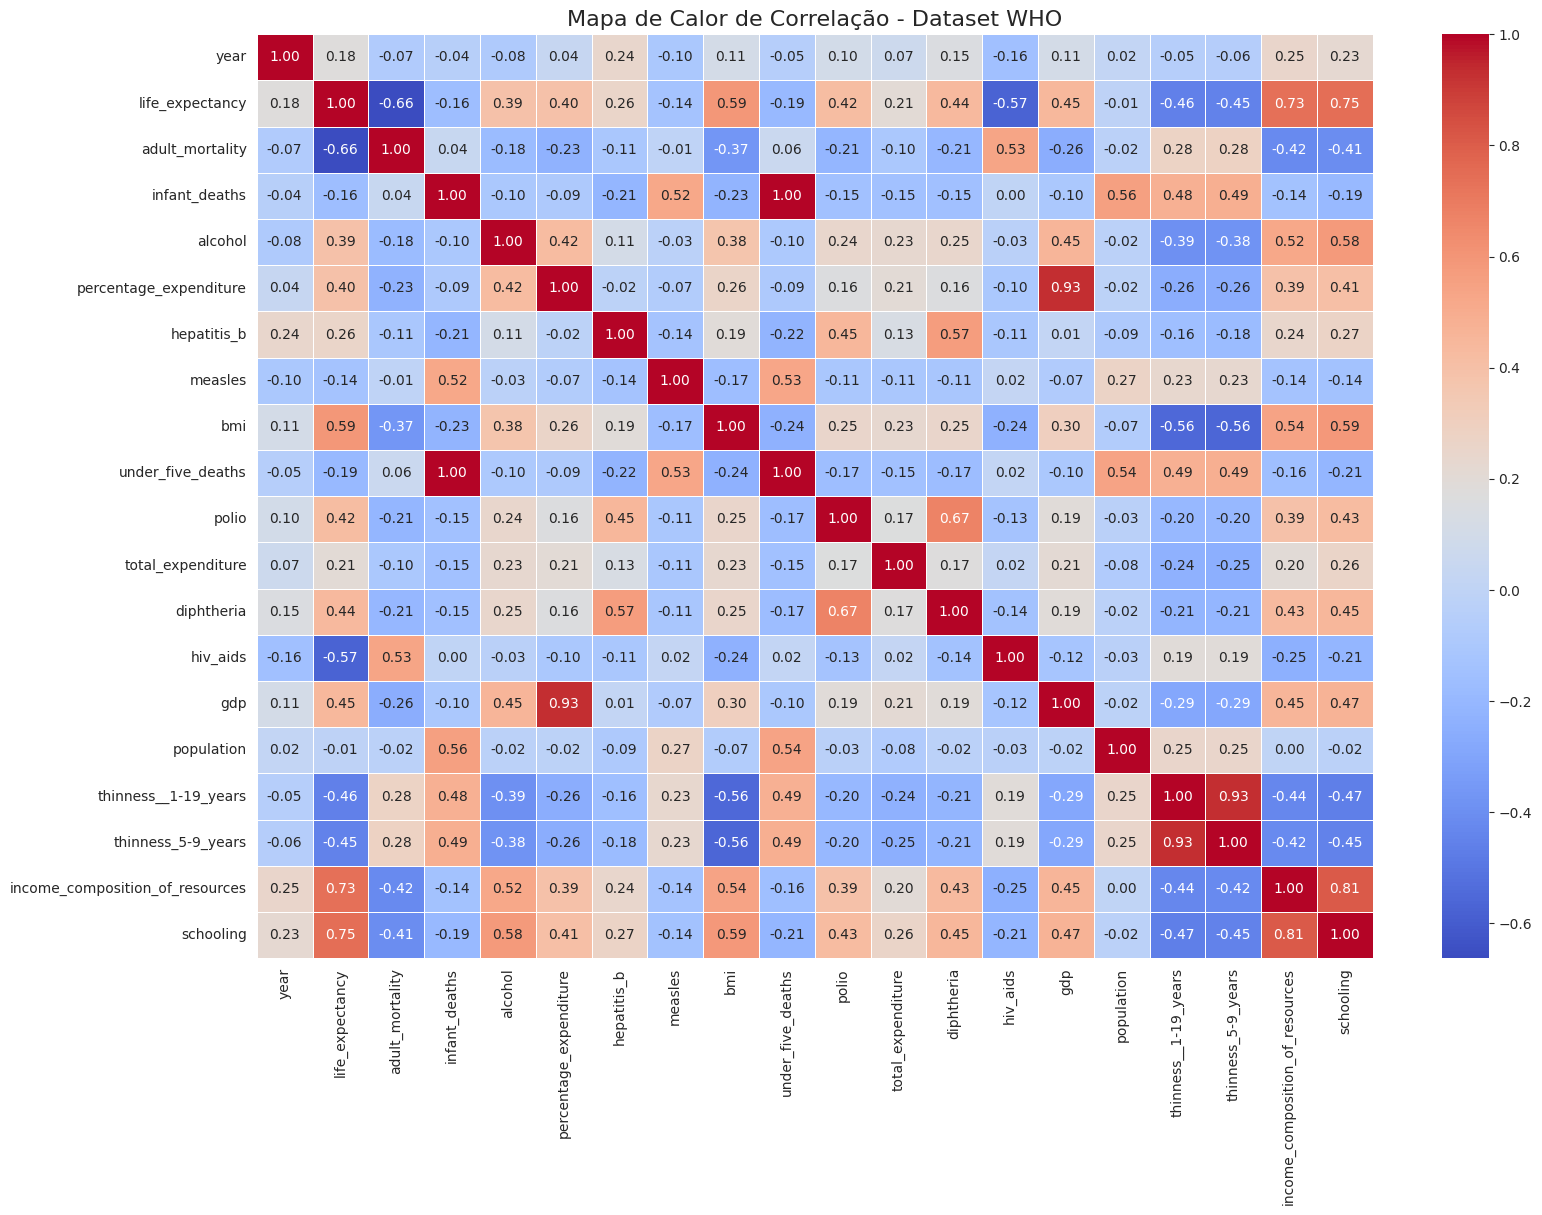

In [62]:
# Calculando a matriz de correlação apenas para colunas numéricas
plt.figure(figsize=(18, 12))
correlation_matrix = df_who.select_dtypes(include=np.number).corr()

# Criando o mapa de calor
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', fmt='.2f', linewidths=.5)
plt.title('Mapa de Calor de Correlação - Dataset WHO', fontsize=16)
plt.show()

**Observações:**

Analisando a matriz de correlação, podemos extrair insights importantes sobre os fatores associados à expectativa de vida:

*   **Preditores de Riqueza e Desenvolvimento (Correlações Positivas Fortes):**
    *   `schooling` (0.75) e `income_composition_of_resources` (0.73) são os campeões. Isso sugere fortemente que **educação e desenvolvimento humano** são os indicadores mais robustos para uma vida longa.
    *   `gdp` (0.45) e `bmi` (0.59) também são significativos, indicando que a riqueza de um país e a nutrição da população são fatores importantes.

*   **Preditores de Crises de Saúde (Correlações Negativas Fortes):**
    *   `adult_mortality` (-0.66) e `hiv_aids` (-0.57) mostram o impacto de crises de saúde e epidemias na longevidade de uma nação.
    *   A **desnutrição**, indicada por `thinness__1-19_years` e `thinness_5-9_years` (correlação de aprox. -0.45), também é um poderoso indicador negativo.

*   **Outras correlações (Correlações Moderadas e surpreendentes):**
    * **O Poder da Imunização:** As taxas de vacinação para `diphtheria` (difteria, +0.44) e `polio` (poliomielite, +0.42) têm uma correlação positiva moderada com a expectativa de vida. Isso quantifica o sucesso de políticas de saúde pública: o controle de doenças infecciosas por meio da vacinação tem um impacto direto e mensurável na longevidade.
    * **O Paradoxo do Álcool:** A variável `alcohol` (+0.39) apresenta uma correlação positiva surpreendente. Isso **não significa que beber álcool aumenta a expectativa de vida**. É um clássico caso de variável de confusão: países com maior poder aquisitivo (e maior expectativa de vida) tendem a ter um consumo de álcool registrado maior. A correlação é com o desenvolvimento econômico, não com o ato de beber.
    * **Mortalidade Infantil:** `infant_deaths` e `under_five_deaths` têm uma correlação negativa mais fraca do que o esperado (aprox. -0.17). Isso ocorre porque são números absolutos, não taxas. Países muito populosos, mesmo que ricos, podem ter um número total de mortes infantis maior do que países pequenos e pobres, mascarando a real força dessa relação.
    * **O Poder da Imunização:** As taxas de vacinação para `diphtheria` (difteria, +0.44) e `polio` (poliomielite, +0.42) têm uma correlação positiva moderada com a expectativa de vida. Isso quantifica o sucesso de políticas de saúde pública: o controle de doenças infecciosas por meio da vacinação tem um impacto direto e mensurável na longevidade.

**Investigação Direcionada**

Vamos confirmar as relações mais fortes com gráficos de dispersão.

**Gráficos de Dispersão para escolaridade e mortalidade adulta**

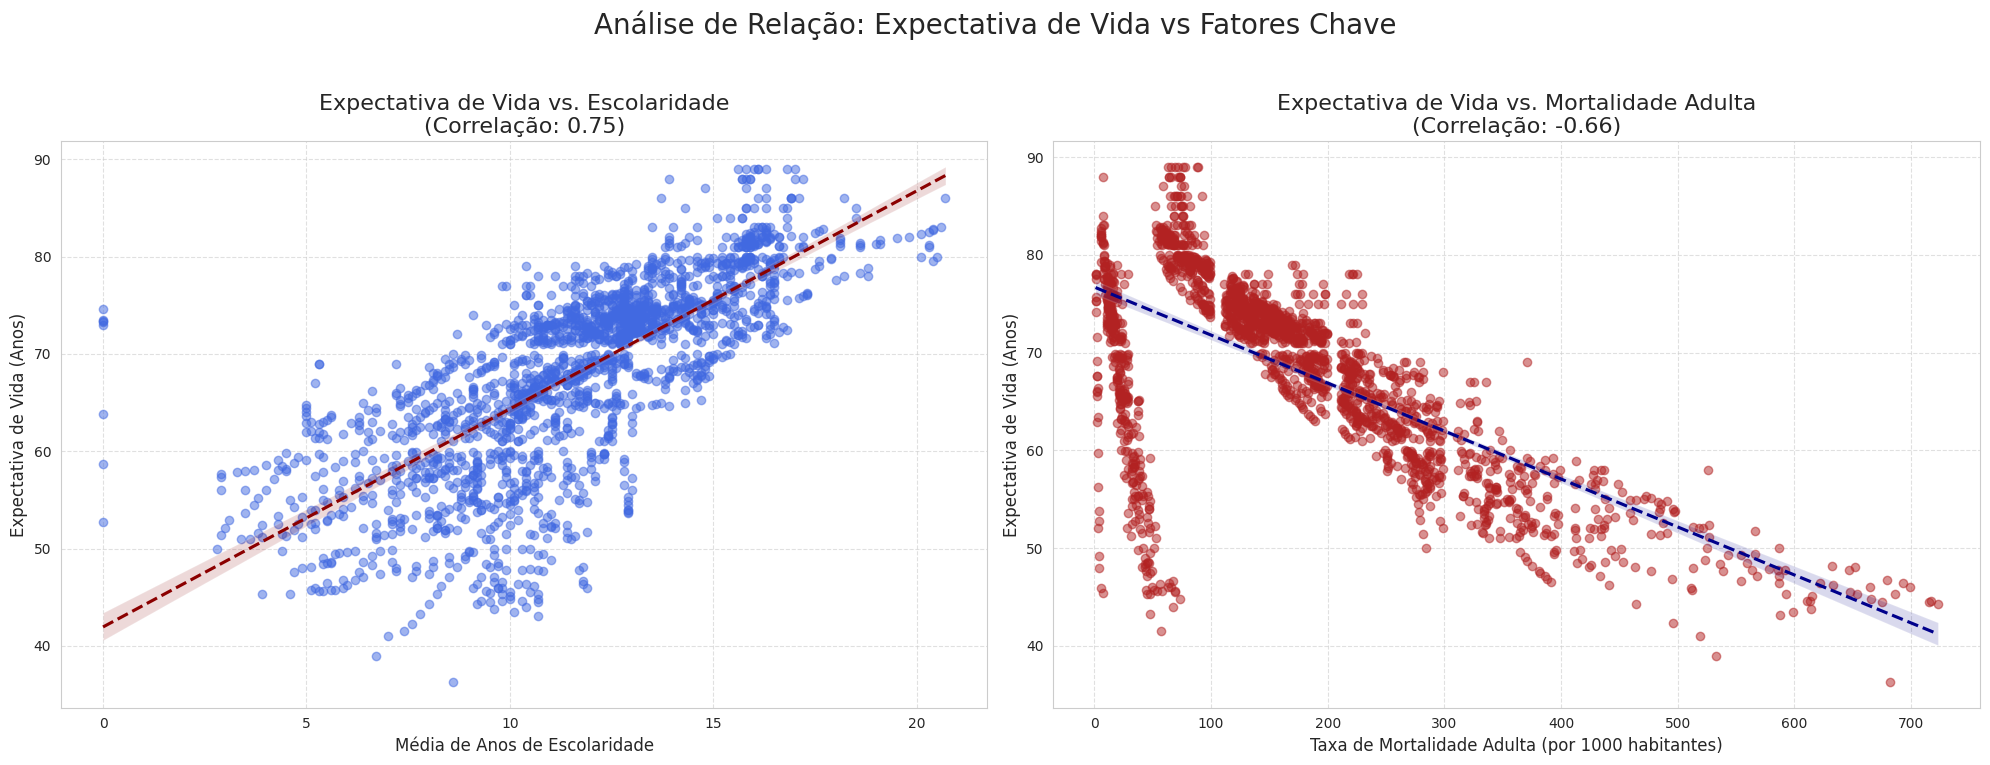

In [63]:
# Calculando os coeficientes de correlação para exibir nos gráficos
corr_schooling = df_who['life_expectancy'].corr(df_who['schooling'])
corr_mortality = df_who['life_expectancy'].corr(df_who['adult_mortality'])

# Configurando a figura e os eixos
fig, axes = plt.subplots(1, 2, figsize=(20, 8))
fig.suptitle('Análise de Relação: Expectativa de Vida vs Fatores Chave', fontsize=20)

# Gráfico 1: Relação Positiva com Escolaridade
sns.regplot(ax=axes[0], x='schooling', y='life_expectancy', data=df_who,
scatter_kws={'alpha': 0.5, 'color': 'royalblue'},
line_kws={'color': 'darkred', 'linestyle': '--'})
axes[0].set_title(f'Expectativa de Vida vs. Escolaridade\n(Correlação: {corr_schooling:.2f})', fontsize=16)
axes[0].set_xlabel('Média de Anos de Escolaridade', fontsize=12)
axes[0].set_ylabel('Expectativa de Vida (Anos)', fontsize=12)
axes[0].grid(True, linestyle='--', alpha=0.6)

# Gráfico 2: Relação Negativa com Mortalidade Adulta
sns.regplot(ax=axes[1], x='adult_mortality', y='life_expectancy', data=df_who,
scatter_kws={'alpha': 0.5, 'color': 'firebrick'},
line_kws={'color': 'darkblue', 'linestyle': '--'})
axes[1].set_title(f'Expectativa de Vida vs. Mortalidade Adulta\n(Correlação: {corr_mortality:.2f})', fontsize=16)
axes[1].set_xlabel('Taxa de Mortalidade Adulta (por 1000 habitantes)', fontsize=12)
axes[1].set_ylabel('Expectativa de Vida (Anos)', fontsize=12)
axes[1].grid(True, linestyle='--', alpha=0.6)

# Ajuste final para evitar sobreposição
plt.tight_layout(rect=[0, 0.03, 1, 0.95])
plt.show()

**Gráficos de Dispersão para GDP e HIV/AIDS**

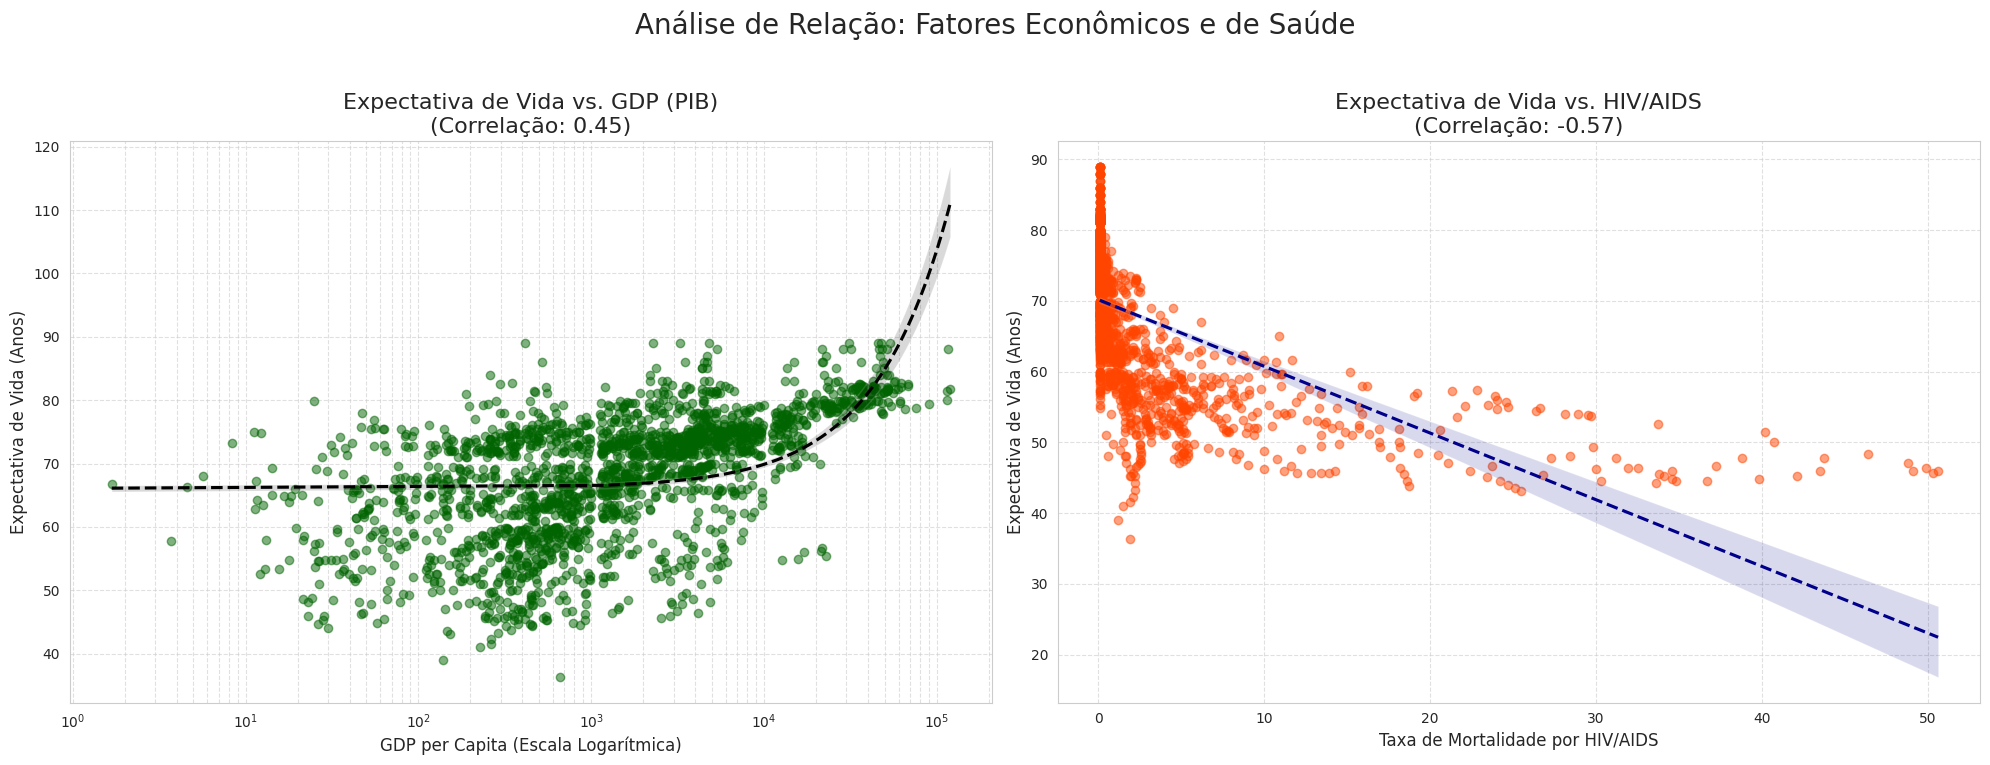

In [64]:
# Calculando os coeficientes de correlação
corr_gdp = df_who['life_expectancy'].corr(df_who['gdp'])
corr_aids = df_who['life_expectancy'].corr(df_who['hiv_aids'])

# Configurando a figura e os eixos
fig, axes = plt.subplots(1, 2, figsize=(20, 8))
fig.suptitle('Análise de Relação: Fatores Econômicos e de Saúde', fontsize=20)

# Gráfico 1: Relação com GDP (escala logarítmica)
sns.regplot(ax=axes[0], x='gdp', y='life_expectancy', data=df_who,
scatter_kws={'alpha': 0.5, 'color': 'darkgreen'},
line_kws={'color': 'black', 'linestyle': '--'})
axes[0].set_xscale('log') # Usando escala log para melhor visualização
axes[0].set_title(f'Expectativa de Vida vs. GDP (PIB)\n(Correlação: {corr_gdp:.2f})', fontsize=16)
axes[0].set_xlabel('GDP per Capita (Escala Logarítmica)', fontsize=12)
axes[0].set_ylabel('Expectativa de Vida (Anos)', fontsize=12)
axes[0].grid(True, which="both", ls="--", alpha=0.6)

# Gráfico 2: Relação com HIV/AIDS
sns.regplot(ax=axes[1], x='hiv_aids', y='life_expectancy', data=df_who,
scatter_kws={'alpha': 0.5, 'color': 'orangered'},
line_kws={'color': 'darkblue', 'linestyle': '--'})
axes[1].set_title(f'Expectativa de Vida vs. HIV/AIDS\n(Correlação: {corr_aids:.2f})', fontsize=16)
axes[1].set_xlabel('Taxa de Mortalidade por HIV/AIDS', fontsize=12)
axes[1].set_ylabel('Expectativa de Vida (Anos)', fontsize=12)
axes[1].grid(True, linestyle='--', alpha=0.6)

# Ajuste final
plt.tight_layout(rect=[0, 0.03, 1, 0.95])
plt.show()

### 2.4. Comparação por Status do País (Desenvolvido vs. Em Desenvolvimento)

Uma das análises mais importantes que podemos fazer é comparar os indicadores entre países classificados como "Desenvolvido" e "Em Desenvolvimento". Isso nos ajuda a entender a magnitude das disparidades globais. Usaremos gráficos de caixa (box plots) para visualizar essas diferenças.

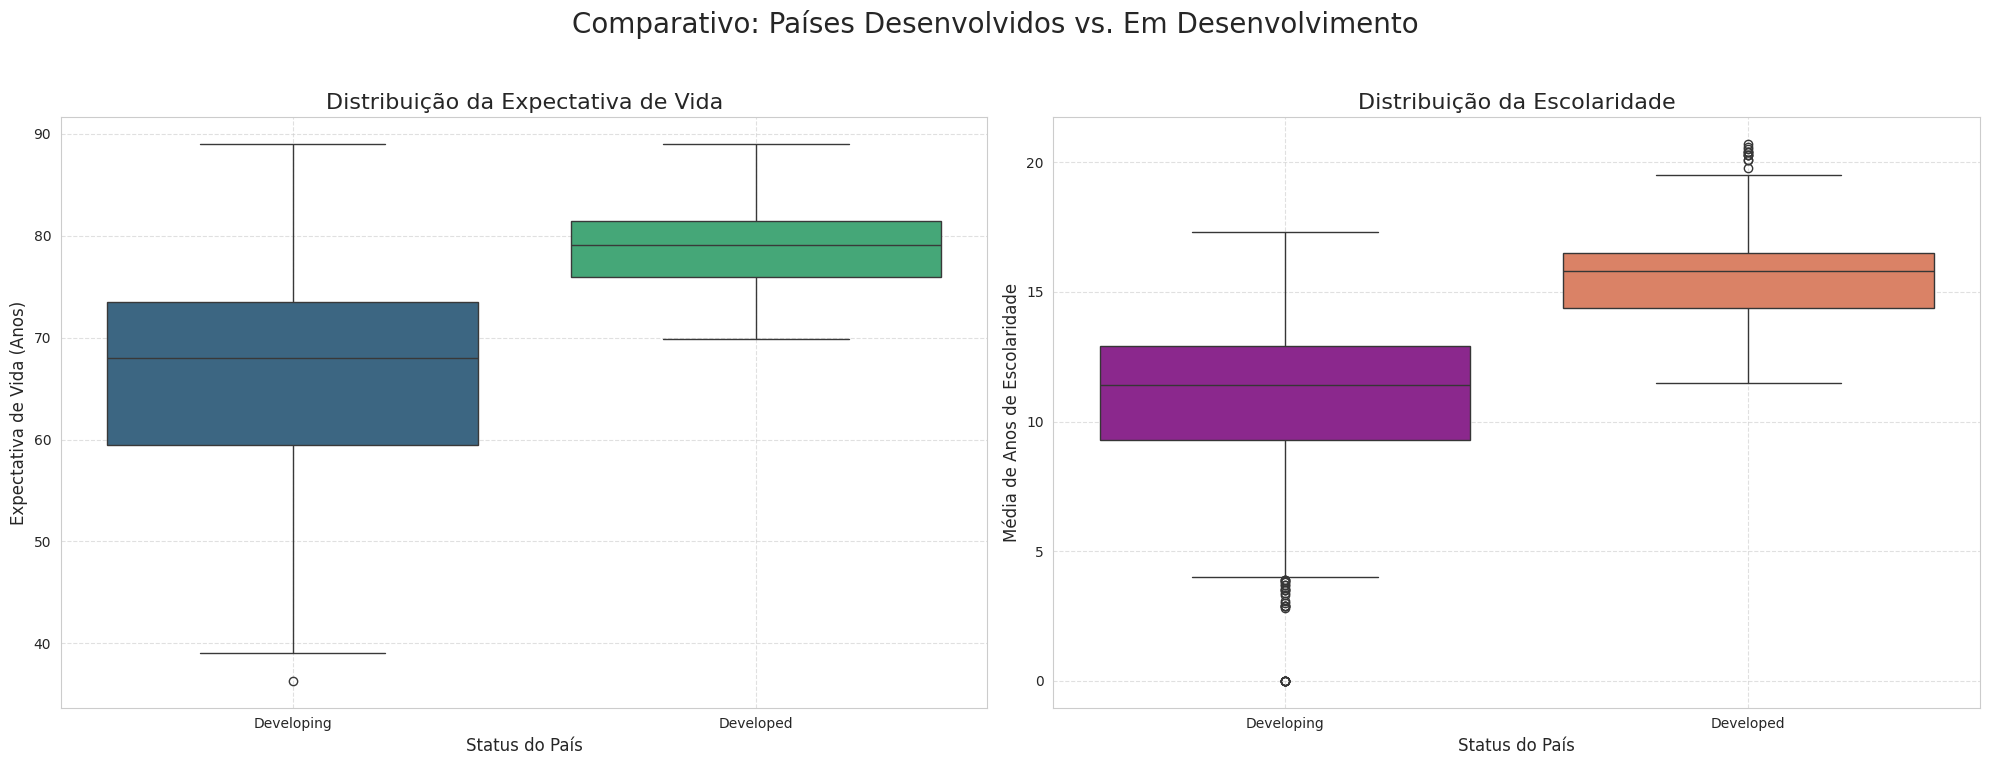

In [65]:
# Configurando a figura para os gráficos
fig, axes = plt.subplots(1, 2, figsize=(20, 8))
fig.suptitle('Comparativo: Países Desenvolvidos vs. Em Desenvolvimento', fontsize=20)

# Gráfico 1: Expectativa de Vida por Status
sns.boxplot(ax=axes[0], x='status', y='life_expectancy', data=df_who, hue='status', palette='viridis', legend=False)
axes[0].set_title('Distribuição da Expectativa de Vida', fontsize=16)
axes[0].set_xlabel('Status do País', fontsize=12)
axes[0].set_ylabel('Expectativa de Vida (Anos)', fontsize=12)
axes[0].grid(True, linestyle='--', alpha=0.6)

# Gráfico 2: Escolaridade por Status
sns.boxplot(ax=axes[1], x='status', y='schooling', data=df_who, hue='status', palette='plasma', legend=False)
axes[1].set_title('Distribuição da Escolaridade', fontsize=16)
axes[1].set_xlabel('Status do País', fontsize=12)
axes[1].set_ylabel('Média de Anos de Escolaridade', fontsize=12)
axes[1].grid(True, linestyle='--', alpha=0.6)

plt.tight_layout(rect=[0, 0.03, 1, 0.95])
plt.show()

**Observações:**

Os gráficos de caixa revelam uma disparidade gritante e inequívoca entre os dois grupos de países:

*   **Expectativa de Vida: Um Abismo entre Grupos**
    *   A mediana da expectativa de vida nos países **desenvolvidos** (próxima a 80 anos) é drasticamente maior que a dos **em desenvolvimento** (cerca de 65 anos).
    *   O ponto mais revelador é a falta de sobreposição: o país com a menor expectativa de vida no grupo desenvolvido ainda está próximo ou acima da mediana do grupo em desenvolvimento. Isso confirma que o status é um divisor de águas.

*   **Escolaridade: O Reflexo do Desenvolvimento**
    *   O padrão se repete na educação. A média de anos de escolaridade é visivelmente maior e mais consistente (distribuição mais compacta) nos países desenvolvidos.
    *   Países em desenvolvimento mostram uma variabilidade muito maior, indicando grandes desigualdades internas no acesso à educação.

### 2.5. Hipóteses da Análise (WHO)

Com base na análise exploratória, formulamos as seguintes hipóteses para a construção de um modelo de regressão:

*   **Hipótese 1: O Capital Humano e o Desenvolvimento são determinantes.** `Schooling` e `income_composition_of_resources` serão as variáveis com os coeficientes positivos mais relevantes, indicando que o desenvolvimento social e humano é um forte impulsionador da longevidade.

*   **Hipótese 2: As condições de saúde prevalecentes são o principal fator negativo.** `Adult_Mortality` e `HIV/AIDS` devem apresentar os coeficientes negativos de maior magnitude, refletindo seu impacto direto na redução da expectativa de vida.

*   **Hipótese 3: O status "Desenvolvido" representa um salto quântico na expectativa de vida.** A variável `Status` é um forte preditor categórico e, quando transformada, terá um peso significativo no modelo.

*   **Hipótese 4: O impacto da saúde preventiva é um pilar secundário.** Variáveis associadas à imunização (`diphtheria`, `polio`) e ao cuidado materno-infantil terão um impacto significativo, embora menor que os fatores socioeconômicos, demonstrando a importância de políticas de saúde pública preventivas.

##3 - Modelagem (WHO)

###3.1 Regressão

In [66]:
df_who.columns

Index(['country', 'year', 'status', 'life_expectancy', 'adult_mortality',
       'infant_deaths', 'alcohol', 'percentage_expenditure', 'hepatitis_b',
       'measles', 'bmi', 'under_five_deaths', 'polio', 'total_expenditure',
       'diphtheria', 'hiv_aids', 'gdp', 'population', 'thinness__1-19_years',
       'thinness_5-9_years', 'income_composition_of_resources', 'schooling'],
      dtype='object')

In [67]:
# codificando variável categórica 'status'
df_who_modeling = pd.get_dummies(df_who, columns=['status'], drop_first=True)

df_who_modeling

,country,year,life_expectancy,adult_mortality,infant_deaths,alcohol,percentage_expenditure,hepatitis_b,measles,bmi,...,total_expenditure,diphtheria,hiv_aids,gdp,population,thinness__1-19_years,thinness_5-9_years,income_composition_of_resources,schooling,status_Developing
15,Afghanistan,2000,54.8,321.0,88,0.01,10.424960,62.0,6532,12.2,...,8.20,24.0,0.1,114.560000,293756.0,2.3,2.5,0.338,5.5,True
14,Afghanistan,2001,55.3,316.0,88,0.01,10.574728,63.0,8762,12.6,...,7.80,33.0,0.1,117.496980,2966463.0,2.1,2.4,0.340,5.9,True
13,Afghanistan,2002,56.2,3.0,88,0.01,16.887351,64.0,2486,13.0,...,7.76,36.0,0.1,187.845950,21979923.0,19.9,2.2,0.341,6.2,True
12,Afghanistan,2003,56.7,295.0,87,0.01,11.089053,65.0,798,13.4,...,8.82,41.0,0.1,198.728544,2364851.0,19.7,19.9,0.373,6.5,True
11,Afghanistan,2004,57.0,293.0,87,0.02,15.296066,67.0,466,13.8,...,8.79,5.0,0.1,219.141353,24118979.0,19.5,19.7,0.381,6.8,True
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2116,Zimbabwe,2011,54.9,464.0,28,6.00,63.750530,94.0,0,29.9,...,6.31,93.0,13.3,839.927936,14386649.0,6.8,6.7,0.452,10.1,True
2115,Zimbabwe,2012,56.6,429.0,26,6.09,92.602336,97.0,0,3.3,...,6.69,95.0,8.8,955.648466,1471826.0,6.5,6.4,0.464,9.8,True
2114,Zimbabwe,2013,58.0,399.0,25,6.39,10.666707,95.0,0,3.8,...,6.88,95.0,6.8,111.227396,155456.0,6.2,6.0,0.488,10.4,True
2113,Zimbabwe,2014,59.2,371.0,23,6.50,10.822595,91.0,0,31.3,...,6.44,91.0,6.3,127.474620,15411675.0,5.9,5.7,0.498,10.3,True


In [68]:
#validando se há valores nulos

for column in df_who.columns:
  print(f"col '{column}': {df_who[column].isnull().sum()} null values")

col 'country': 0 null values
col 'year': 0 null values
col 'status': 0 null values
col 'life_expectancy': 0 null values
col 'adult_mortality': 0 null values
col 'infant_deaths': 0 null values
col 'alcohol': 0 null values
col 'percentage_expenditure': 0 null values
col 'hepatitis_b': 0 null values
col 'measles': 0 null values
col 'bmi': 0 null values
col 'under_five_deaths': 0 null values
col 'polio': 0 null values
col 'total_expenditure': 0 null values
col 'diphtheria': 0 null values
col 'hiv_aids': 0 null values
col 'gdp': 0 null values
col 'population': 0 null values
col 'thinness__1-19_years': 0 null values
col 'thinness_5-9_years': 0 null values
col 'income_composition_of_resources': 0 null values
col 'schooling': 0 null values


In [69]:
# separando features e target
X = df_who_modeling.drop('life_expectancy', axis=1)
y = df_who_modeling['life_expectancy']

# removendo a coluna não numérica (country)
X = X.drop('country', axis=1)

# normalizando os dados
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

# dividindo entre treino e teste
X_train, X_test, y_train, y_test = train_test_split(
    X_scaled, y, test_size=0.2, random_state=42
)


#### Dividindo os modelos

In [70]:

# Regressão Linear Múltipla
lr = LinearRegression()
lr.fit(X_train, y_train)
lr_pred = lr.predict(X_test)

# Grau 2
poly = PolynomialFeatures(degree=2)
X_poly_train = poly.fit_transform(X_train)
X_poly_test = poly.transform(X_test)

lr_poly = LinearRegression()
lr_poly.fit(X_poly_train, y_train)
poly_pred = lr_poly.predict(X_poly_test)

# Arvore de decisão
tree = DecisionTreeRegressor(random_state=42)
tree.fit(X_train, y_train)
tree_pred = tree.predict(X_test)

# Adaline
class Adaline:
    def __init__(self, learning_rate=0.01, epochs=100):
        self.lr = learning_rate
        self.epochs = epochs

    def fit(self, X, y):
        self.weights = np.zeros(X.shape[1])
        self.bias = 0
        self.losses = []

        for _ in range(self.epochs):
            y_pred = self.predict(X)
            error = y - y_pred
            self.weights += self.lr * X.T.dot(error) / len(X)
            self.bias += self.lr * error.mean()
            loss = (error**2).mean()
            self.losses.append(loss)
        return self

    def predict(self, X):
        return X.dot(self.weights) + self.bias

adaline = Adaline(learning_rate=0.01, epochs=100)
adaline.fit(X_train, y_train)
adaline_pred = adaline.predict(X_test)

# MLP
mlp = MLPRegressor(hidden_layer_sizes=(100, 50), max_iter=1000, random_state=42)
mlp.fit(X_train, y_train)
mlp_pred = mlp.predict(X_test)

#SVM
svr = SVR(kernel='rbf', C=100, gamma='scale')
svr.fit(X_train, y_train)
svr_pred = svr.predict(X_test)

#Random Forest
rf = RandomForestRegressor(n_estimators=100, random_state=42)
rf.fit(X_train, y_train)
rf_pred = rf.predict(X_test)

#Gradient Boosting
gb = GradientBoostingRegressor(n_estimators=100, random_state=42)
gb.fit(X_train, y_train)
gb_pred = gb.predict(X_test)



Avaliando os modelos

In [71]:
models = {
    'Linear Regression': lr_pred,
    'Polynomial Regression': poly_pred,
    'Decision Tree': tree_pred,
    'Adaline': adaline_pred,
    'MLP': mlp_pred,
    'SVM': svr_pred,
    'Random Forest': rf_pred,
    'Gradient Boosting': gb_pred
}

results = []
for name, pred in models.items():
    rmse = np.sqrt(mean_squared_error(y_test, pred))
    r2 = r2_score(y_test, pred)
    results.append([name, rmse, r2])

results_df = pd.DataFrame(results, columns=['Model', 'RMSE', 'R²'])
print(results_df.sort_values(by='RMSE'))

                   Model       RMSE        R²
6          Random Forest   1.966076  0.962475
7      Gradient Boosting   2.417837  0.943250
4                    MLP   2.431992  0.942583
5                    SVM   2.456580  0.941416
2          Decision Tree   3.156062  0.903305
1  Polynomial Regression   3.240408  0.898067
0      Linear Regression   4.061407  0.839872
3                Adaline  25.225860 -5.177418


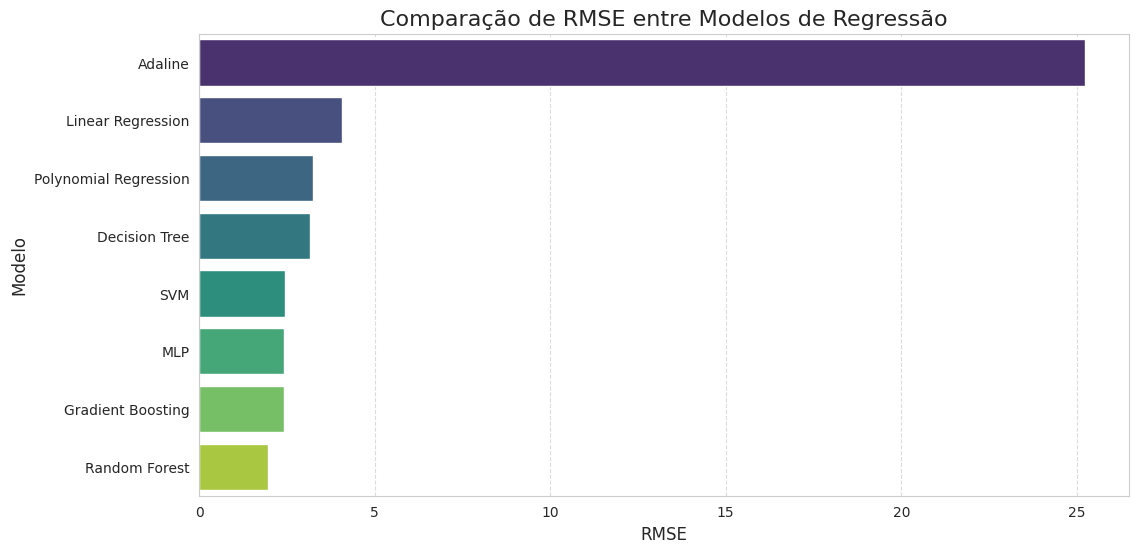

In [72]:
# Criando um DataFrame para os resultados
results_df = pd.DataFrame(results, columns=['Model', 'RMSE', 'R²'])
results_df = results_df.sort_values(by='RMSE', ascending=False) # Ordenar para o gráfico

# Gráfico de Barras para RMSE
plt.figure(figsize=(12, 6))
sns.barplot(x='RMSE', y='Model', data=results_df, palette='viridis', hue='Model', legend=False)
plt.title('Comparação de RMSE entre Modelos de Regressão', fontsize=16)
plt.xlabel('RMSE', fontsize=12)
plt.ylabel('Modelo', fontsize=12)
plt.grid(axis='x', linestyle='--', alpha=0.7)
plt.show()



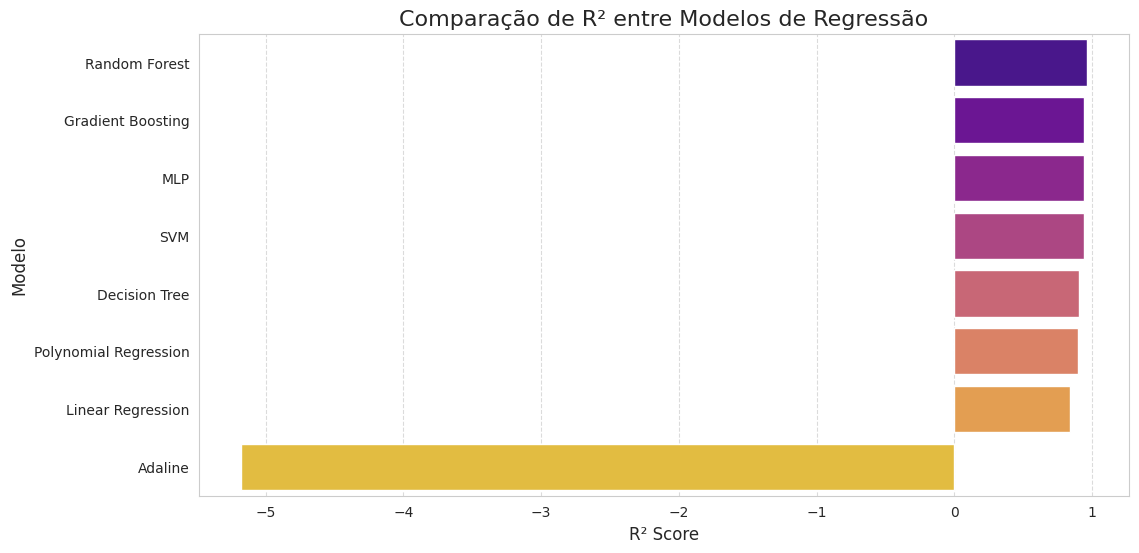

In [73]:
# Gráfico de Barras para R²
plt.figure(figsize=(12, 6))
sns.barplot(x='R²', y='Model', data=results_df.sort_values(by='R²', ascending=False), palette='plasma', hue='Model', legend=False)
plt.title('Comparação de R² entre Modelos de Regressão', fontsize=16)
plt.xlabel('R² Score', fontsize=12)
plt.ylabel('Modelo', fontsize=12)
plt.grid(axis='x', linestyle='--', alpha=0.7)
plt.show()

Otimização do melhor modelo

In [74]:
# Otimizar Gradient Boosting
param_grid = {
    'n_estimators': [100, 200],
    'learning_rate': [0.05, 0.1],
    'max_depth': [3, 5]
}

gb = GradientBoostingRegressor(random_state=42)
grid_search = GridSearchCV(gb, param_grid, cv=5, scoring='neg_mean_squared_error')
grid_search.fit(X_train, y_train)

# Melhores hiperparâmetros
print(grid_search.best_params_)
best_gb = grid_search.best_estimator_

{'learning_rate': 0.1, 'max_depth': 5, 'n_estimators': 200}


In [75]:
# Otimizar Gradient Boosting
param_grid = {
    'n_estimators': [100, 200],
    'learning_rate': [0.05, 0.1],
    'max_depth': [3, 5]
}

gb = GradientBoostingRegressor(random_state=42)
grid_search = GridSearchCV(gb, param_grid, cv=5, scoring='neg_mean_squared_error')
grid_search.fit(X_train, y_train)

# Melhores hiperparâmetros
print("Melhores hiperparâmetros para Gradient Boosting:", grid_search.best_params_)
best_gb = grid_search.best_estimator_

# Avaliar o melhor modelo Gradient Boosting no conjunto de teste
best_gb_pred = best_gb.predict(X_test)
best_gb_rmse = np.sqrt(mean_squared_error(y_test, best_gb_pred))
best_gb_r2 = r2_score(y_test, best_gb_pred)

print(f"\nAvaliação do melhor modelo Gradient Boosting:")
print(f"RMSE: {best_gb_rmse:.2f}")
print(f"R² Score: {best_gb_r2:.2f}")

# Visualização da performance dos modelos

# Criando um DataFrame para os resultados
results_df = pd.DataFrame(results, columns=['Model', 'RMSE', 'R²'])
results_df = results_df.sort_values(by='RMSE', ascending=False) # Ordenar para o gráfico

Melhores hiperparâmetros para Gradient Boosting: {'learning_rate': 0.1, 'max_depth': 5, 'n_estimators': 200}

Avaliação do melhor modelo Gradient Boosting:
RMSE: 1.97
R² Score: 0.96


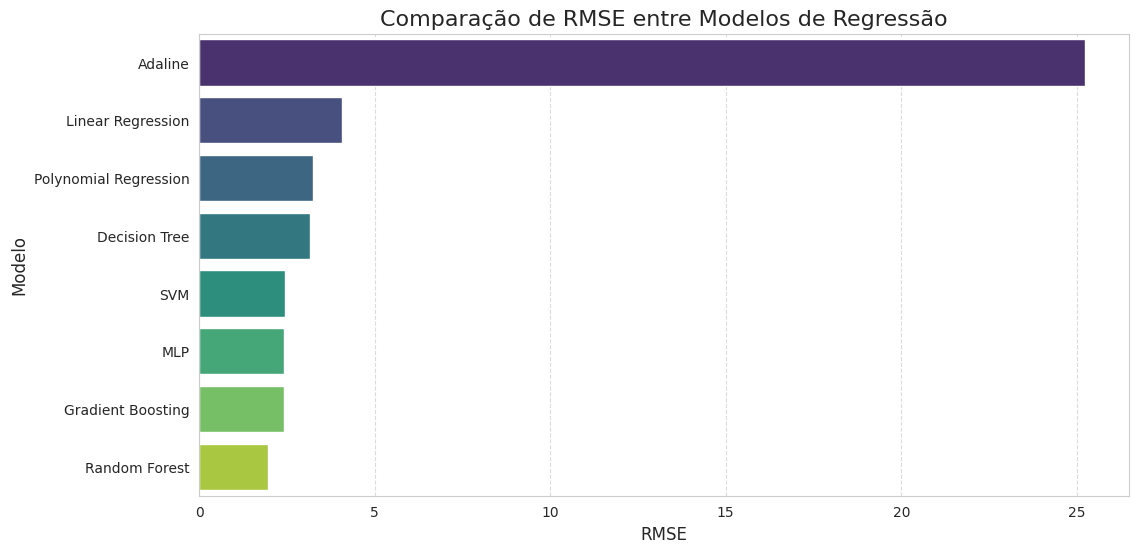

                   Model       RMSE        R²
6          Random Forest   1.966076  0.962475
7      Gradient Boosting   2.417837  0.943250
4                    MLP   2.431992  0.942583
5                    SVM   2.456580  0.941416
2          Decision Tree   3.156062  0.903305
1  Polynomial Regression   3.240408  0.898067
0      Linear Regression   4.061407  0.839872
3                Adaline  25.225860 -5.177418

Modelo com menor RMSE: Random Forest


In [76]:
# Gráfico de Barras para RMSE
plt.figure(figsize=(12, 6))
sns.barplot(x='RMSE', y='Model', data=results_df, palette='viridis', hue='Model', legend=False)
plt.title('Comparação de RMSE entre Modelos de Regressão', fontsize=16)
plt.xlabel('RMSE', fontsize=12)
plt.ylabel('Modelo', fontsize=12)
plt.grid(axis='x', linestyle='--', alpha=0.7)
plt.show()

lower_rmse_model = results_df[results_df['RMSE'] == min(results_df['RMSE'])]
[lower_rmse_model_name] = lower_rmse_model['Model'].values
print(results_df.sort_values(by='RMSE'))
print()
print(f"Modelo com menor RMSE: {lower_rmse_model_name}")

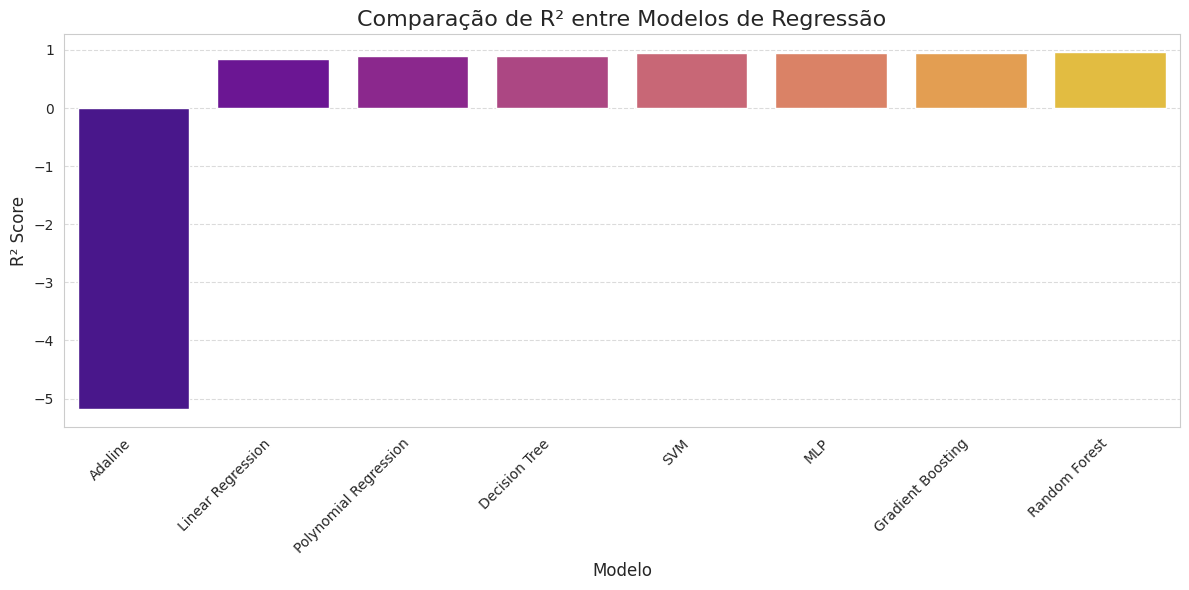

Modelos com R² inválido: ['Adaline']
Melhor modelo com R²: Random Forest


In [77]:
# Gráfico de Barras para R²
plt.figure(figsize=(12, 6))
sns.barplot(x='Model', y='R²', data=results_df.sort_values(by='R²', ascending=True), palette='plasma', hue='Model', legend=False)
plt.title('Comparação de R² entre Modelos de Regressão', fontsize=16)
plt.xlabel('Modelo', fontsize=12)
plt.ylabel('R² Score', fontsize=12)
plt.xticks(rotation=45, ha='right')
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.tight_layout()
plt.show()

invalid_r2_models = results_df[results_df['R²'] < 0]
invalid_r2_models_name = invalid_r2_models['Model'].values
best_r2_model = results_df[results_df['R²'] == max(results_df['R²'])]
[best_r2_model_name] = best_r2_model['Model'].values

print(f"Modelos com R² inválido: {invalid_r2_models_name}")
print(f"Melhor modelo com R²: {best_r2_model_name}")

# Interpretação e Visualização (Data Apps)

# **Introdução**

Este trabalho demonstra como a análise de dados e a criação de aplicações interativas, conhecidas como "DataApps", podem simplificar a compreensão de temas complexos. Foram desenvolvidas duas ferramentas para explorar dados públicos: uma para análise de Acidentes de Trânsito no Brasil e outra sobre Expectativa de Vida no mundo. O objetivo é transformar dados brutos em visualizações claras e acessíveis, permitindo que qualquer pessoa possa extrair informações valiosas sem precisar programar.



# **Código-Fonte das Aplicações Interativas**

O código a seguir, desenvolvido em Python, é a base para as duas aplicações. Ele realiza o tratamento dos dados e gera os gráficos interativos.



In [78]:
import pandas as pd
import matplotlib.pyplot as plt
import gradio as gr
import numpy as np
import gdown

# ID do arquivo Boletim de Acidente de Trânsito CSV no Google Drive (público)
file_id_boletim = "1KBQRR3rCL_6b5jmLh-ZMBl0kPSuKIg0L"

# ID do arquivo Expectativa de Vida - Life Expectancy CSV no Google Drive (público)
file_id_expectativa_vida = "1Nc7rvZ1VjZD-PYMqOXjQTAbMlWRr0p60"

# --- Bloco 1: Carregamento e Limpeza dos Dados ---

# Tenta carregar e preparar o dataset de Acidentes de Trânsito
try:

    # Baixa e lê o CSV diretamente
    url_boletim = f"https://drive.google.com/uc?id={file_id_boletim}"
    gdown.download(url_boletim, "BoletimDeAcidenteDeTrânsito.csv", quiet=True)
    df_acidentes = pd.read_csv('BoletimDeAcidenteDeTrânsito.csv', sep=';', encoding='latin1', on_bad_lines='warn')

    # Converte a data e remove linhas com dados essenciais faltantes
    df_acidentes['data_inversa'] = pd.to_datetime(df_acidentes['data_inversa'], errors='coerce')
    df_acidentes.dropna(subset=['data_inversa', 'uf', 'causa_acidente', 'tipo_acidente', 'latitude', 'longitude'], inplace=True)

    # Converte colunas de coordenadas para número, substituindo vírgula por ponto
    df_acidentes['latitude'] = df_acidentes['latitude'].astype(str).str.replace(',', '.').astype(float)
    df_acidentes['longitude'] = df_acidentes['longitude'].astype(str).str.replace(',', '.').astype(float)

    # Cria a coluna 'dia_semana' em português de forma robusta
    map_dias_pt = {
        'Monday': 'segunda-feira', 'Tuesday': 'terça-feira', 'Wednesday': 'quarta-feira',
        'Thursday': 'quinta-feira', 'Friday': 'sexta-feira', 'Saturday': 'sábado', 'Sunday': 'domingo'
    }
    df_acidentes['dia_semana'] = df_acidentes['data_inversa'].dt.day_name().map(map_dias_pt)

    # Prepara listas para os filtros da interface
    ufs_disponiveis = sorted(df_acidentes['uf'].unique())
    dias_disponiveis = ['segunda-feira', 'terça-feira', 'quarta-feira', 'quinta-feira', 'sexta-feira', 'sábado', 'domingo']

except FileNotFoundError:
    print("Erro: O arquivo 'Boletim de Acidente de Trânsito.csv' não foi encontrado.")
    df_acidentes = pd.DataFrame()
    ufs_disponiveis, dias_disponiveis = [], []

# Tenta carregar e preparar o dataset de Expectativa de Vida
try:
    # Baixa e lê o CSV diretamente
    url_expectativa_vida = f"https://drive.google.com/uc?id={file_id_expectativa_vida}"
    gdown.download(url_expectativa_vida, "ExpectativaDeVida.csv", quiet=True)
    df_vida = pd.read_csv('ExpectativaDeVida.csv')

    # Limpa espaços em branco nos nomes das colunas
    df_vida.columns = df_vida.columns.str.strip()

    # Preenche valores numéricos faltantes com a mediana para fins de visualização
    for col in df_vida.select_dtypes(include=np.number).columns:
        df_vida[col] = df_vida[col].fillna(df_vida[col].median())

    paises_disponiveis = sorted(df_vida['Country'].unique())

except FileNotFoundError:
    print("Erro: O arquivo 'Expectativa de Vida - Life Expectancy (WHO).csv' não foi encontrado.")
    df_vida = pd.DataFrame()
    paises_disponiveis = []


In [79]:


# --- Bloco 2: Funções de Análise para os Apps ---

def analisar_acidentes(uf, dia):
    """Filtra os dados de acidentes e gera gráficos e estatísticas."""
    if df_acidentes.empty:
        return None, None, "Dataset de acidentes não carregado."

    df_filtrado = df_acidentes[df_acidentes['uf'] == uf]
    if dia != "Todos":
        df_filtrado = df_filtrado[df_filtrado['dia_semana'] == dia]

    if df_filtrado.empty:
        return None, None, "Nenhum dado encontrado para a seleção."

    total_acidentes = len(df_filtrado)
    total_mortos = int(df_filtrado['mortos'].sum())
    total_feridos = int(df_filtrado['feridos'].sum())
    estatisticas = (f"Resumo para {uf} ({dia}):\n"
                    f"  - Total de Acidentes: {total_acidentes}\n"
                    f"  - Total de Mortos: {total_mortos}\n"
                    f"  - Total de Feridos: {total_feridos}")

    plt.style.use('seaborn-v0_8-talk')

    # Gráfico de Causas
    plt.figure(figsize=(12, 8))
    df_filtrado['causa_acidente'].value_counts().nlargest(10).sort_values().plot(kind='barh', color='#3498db')
    plt.title(f'Top 10 Causas de Acidentes em {uf}', fontsize=16)
    plt.xlabel('Número de Ocorrências', fontsize=12)
    plt.ylabel('Causa do Acidente', fontsize=12)
    plt.tight_layout()
    plot_causas_path = "acidentes_causas.png"
    plt.savefig(plot_causas_path)
    plt.close()

    # Gráfico de Mapa
    plt.figure(figsize=(10, 10))
    plt.scatter(df_filtrado['longitude'], df_filtrado['latitude'], alpha=0.2, s=15, c='red')
    plt.title(f'Mapa de Concentração de Acidentes em {uf}', fontsize=16)
    plt.xlabel('Longitude', fontsize=12)
    plt.ylabel('Latitude', fontsize=12)
    plt.grid(True)
    plot_mapa_path = "acidentes_mapa.png"
    plt.savefig(plot_mapa_path)
    plt.close()

    return plot_causas_path, plot_mapa_path, estatisticas

def analisar_expectativa_vida(pais):
    """Filtra os dados de expectativa de vida e gera gráficos."""
    if df_vida.empty:
        return None, None, "Dataset de expectativa de vida não carregado."

    df_pais = df_vida[df_vida['Country'] == pais].sort_values('Year')

    media_vida = df_pais['Life expectancy'].mean()
    media_escolaridade = df_pais['Schooling'].mean()
    estatisticas = (f"Resumo para {pais} (2000-2015):\n"
                    f"  - Média da Expectativa de Vida: {media_vida:.1f} anos\n"
                    f"  - Média de Anos de Escolaridade: {media_escolaridade:.1f} anos")

    plt.style.use('seaborn-v0_8-talk')

    # Gráfico de Evolução
    plt.figure(figsize=(12, 7))
    plt.plot(df_pais['Year'], df_pais['Life expectancy'], marker='o', linestyle='-', color='#2ecc71')
    plt.title(f'Evolução da Expectativa de Vida em {pais}', fontsize=16)
    plt.xlabel('Ano', fontsize=12)
    plt.ylabel('Expectativa de Vida (anos)', fontsize=12)
    plt.grid(True, linestyle='--', alpha=0.6)
    plt.ylim(max(0, df_vida['Life expectancy'].min() - 5), df_vida['Life expectancy'].max() + 5)
    plot_evolucao_path = "vida_evolucao.png"
    plt.savefig(plot_evolucao_path)
    plt.close()

    # Gráfico de Relação com Escolaridade
    plt.figure(figsize=(12, 7))
    plt.scatter(df_pais['Schooling'], df_pais['Life expectancy'], color='#9b59b6', s=50)
    plt.title(f'Expectativa de Vida vs. Escolaridade em {pais}', fontsize=16)
    plt.xlabel('Média de Anos de Escolaridade', fontsize=12)
    plt.ylabel('Expectativa de Vida (anos)', fontsize=12)
    plt.grid(True, linestyle='--', alpha=0.6)
    plot_relacao_path = "vida_relacao.png"
    plt.savefig(plot_relacao_path)
    plt.close()

    return plot_evolucao_path, plot_relacao_path, estatisticas

# --- Bloco 3: Construção das Interfaces Gradio ---

# Interface 1: Acidentes de Trânsito
app_acidentes = gr.Interface(
    fn=analisar_acidentes,
    inputs=[
        gr.Dropdown(choices=ufs_disponiveis, label="Selecione o Estado (UF)", value=ufs_disponiveis[0] if ufs_disponiveis else None),
        gr.Dropdown(choices=["Todos"] + dias_disponiveis, label="Selecione o Dia da Semana", value="Todos")
    ],
    outputs=[
        gr.Image(type="filepath", label="Top 10 Causas de Acidentes", height=500),
        gr.Image(type="filepath", label="Mapa de Concentração de Acidentes", height=500),
        gr.Textbox(label="Estatísticas Resumidas", lines=10)
    ],
    title="DataApp: Análise de Acidentes de Trânsito (PRF)",
    description="Explore os dados de acidentes nas rodovias federais. Selecione um estado e um dia da semana para começar."
)

# Interface 2: Expectativa de Vida
app_vida = gr.Interface(
    fn=analisar_expectativa_vida,
    inputs=gr.Dropdown(choices=paises_disponiveis, label="Selecione o País", value="Brazil" if "Brazil" in paises_disponiveis else (paises_disponiveis[0] if paises_disponiveis else None)),
    outputs=[
        gr.Image(type="filepath", label="Evolução da Expectativa de Vida (2000-2015)", height=500),
        gr.Image(type="filepath", label="Relação com Anos de Escolaridade", height=500),
        gr.Textbox(label="Estatísticas Resumidas", lines=10)
    ],
    title="DataApp: Análise de Expectativa de Vida (OMS)",
    description="Explore como a expectativa de vida e a escolaridade evoluíram em diferentes países entre 2000 e 2015."
)


# --- Bloco 4: Execução dos Apps ---
if __name__ == "__main__":
    app = gr.TabbedInterface(
        interface_list=[app_acidentes, app_vida],
        tab_names=["Acidentes de Trânsito", "Expectativa de Vida"]
    )
    app.launch()

It looks like you are running Gradio on a hosted Jupyter notebook, which requires `share=True`. Automatically setting `share=True` (you can turn this off by setting `share=False` in `launch()` explicitly).

Colab notebook detected. To show errors in colab notebook, set debug=True in launch()
* Running on public URL: https://0221e40f33dac62261.gradio.live

This share link expires in 1 week. For free permanent hosting and GPU upgrades, run `gradio deploy` from the terminal in the working directory to deploy to Hugging Face Spaces (https://huggingface.co/spaces)


### **Conclusão**

As ferramentas desenvolvidas transformam com sucesso conjuntos de dados complexos em painéis interativos e de fácil compreensão. Elas permitem a exploração de padrões sobre as causas de acidentes de trânsito e os fatores que impactam a expectativa de vida, oferecendo insights valiosos para gestores e para o público. Como próximo passo, modelos preditivos de machine learning poderiam ser integrados a essas aplicações para adicionar funcionalidades de previsão de riscos e tendências futuras.







